# Uncovering Healthcare Inefficiencies - EDA and Data Preprocesssing 

This notebook focuses on exploring and preprocessing the Market Saturation and Utilization Data from the Centers for Medicare & Medicaid Services (CMS). The dataset, obtained via the CMS API, provides valuable insights into Medicare Fee-for-Service (FFS) claims, facilitating the analysis of market saturation and healthcare service utilization across states and counties.

---

### Import Libaries 

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pymysql

from tqdm import tqdm
import os

from tabulate import tabulate

from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from scipy import stats

from sklearn.model_selection import train_test_split

import powerbiclient

from powerbiclient import QuickVisualize, get_dataset_config, Report
from powerbiclient.authentication import DeviceCodeLoginAuthentication

from geopy.geocoders import Bing
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # supress warning 

### Import Data

In [3]:
# Read in data - might take a while because there 1m+ rows
data = pd.read_csv('data/cms_data.csv', low_memory=False) # we use 'low_memory=False' to isntruct Pandas to use more memorry and avoid mixed data types 

When reading in the data, Python gave a warning that column 12 (index 13) has mixed data types. Let's take a look.

In [4]:
data.head()

,reference_period,type_of_service,aggregation_level,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,...,number_of_fee_for_service_beneficiaries_change,number_of_providers_change,average_number_of_users_per_provider_change,percentage_of_users_out_of_ffs_beneficiaries_change,number_of_users_change,average_number_of_providers_per_county_change,number_of_dual_eligible_users_change,percentage_of_dual_eligible_users_out_of_total_users_change,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change,total_payment_change
0,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,,,"36,122,263","8,814",495.69,...,5.81%,0.34%,1.28%,( 3.97%),1.62%,1.19%,( 4.89%),( 6.43%),( 1.20%),1.80%
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AL,--ALL--,01,,"547,486",146,501.47,...,3.53%,( 2.01%),0.86%,( 4.57%),( 1.17%),1.82%,(11.81%),(10.78%),( 1.35%),( 2.76%)
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AK,--ALL--,02,,"91,480",33,254.97,...,38.93%,3.13%,19.77%,(11.11%),23.52%,0.15%,0.67%,(18.50%),0.27%,21.32%
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AZ,--ALL--,04,,"740,278",170,401.34,...,8.98%,( 3.41%),6.63%,( 5.44%),3.00%,( 5.90%),( 1.55%),( 4.38%),( 6.60%),7.07%
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AR,--ALL--,05,,"437,616",86,628.07,...,3.79%,( 3.37%),5.17%,( 2.14%),1.62%,( 7.84%),,,,3.64%


### Create Database (`healthcare-market-saturation-fraud`) 

In [22]:
# connection parameters
username = "root"
password = "Misty#78182"
hostName = "127.0.0.1"
database = "healthcare-market-saturation-fraud"

# Connect to the database
try:
    conn = pymysql.connect(host=hostName, 
                           port=3306,
                           user=username,
                           password=password, 
                           db=database,
                           local_infile=True)  # Enable local file loading
    print("Connection to SQL was successful!")
except pymysql.MySQLError as e:
    print(f"Error connecting to MySQL: {e}")
    exit()

Connection to SQL was successful!


In [23]:
# define the file path
file_path = "data/cms_data_sql.csv"

# function to count the number of lines in the file
def count_lines(file_path):
    with open(file_path, 'r') as file:
        return sum(1 for _ in file)

# count total lines in the file (excluding header)
total_lines = count_lines(file_path) - 1  # Subtracting header row

cursor = conn.cursor()

try:
    # check if the table already contains data
    cursor.execute("SELECT COUNT(*) FROM `healthcare-market-saturation-fraud`;")
    row_count = cursor.fetchone()[0]

    if row_count > 0:
        print(f"Table already contains {row_count} rows. Skipping data import.")
    else:
        # create SQL command for importing data
        sql = f"""
        LOAD DATA LOCAL INFILE '{file_path}'
        INTO TABLE `healthcare-market-saturation-fraud`
        FIELDS TERMINATED BY ','
        ENCLOSED BY '"'
        LINES TERMINATED BY '\n'
        IGNORE 1 LINES
        (reference_period, type_of_service, aggregation_level, state, county, state_fips, county_fips, num_fee_service_benef, num_providers, avg_users_per_provider, pct_users_out_ffs_benef, num_users, avg_providers_per_county, num_dual_eligible_users, pct_dual_eligible_users_out_total_users, percent_dual_elig_ffs, total_payment, moratorium, num_fee_service_benef_dual_color, num_fee_service_benef_desc, num_providers_dual_color, num_providers_desc, avg_users_per_provider_dual_color, avg_users_per_provider_desc, pct_users_out_ffs_benef_dual_color, pct_users_out_ffs_benef_desc, num_users_dual_color, num_users_desc, avg_providers_per_county_dual_color, avg_providers_per_county_desc, num_dual_eligible_users_dual_color, num_dual_eligible_users_desc, pct_dual_eligible_total_users_dual_color, pct_dual_eligible_total_users_desc, pct_dual_eligible_ffs_dual_color, pct_dual_eligible_ffs_desc, total_payment_dual_color, total_payment_desc, num_fee_service_benef_change, num_providers_change, avg_users_per_provider_change, pct_users_out_ffs_benef_change, num_users_change, avg_providers_per_county_change, num_dual_eligible_users_change, pct_dual_eligible_users_out_total_users_change, pct_dual_eligible_ffs_change, total_payment_change);
        """

        # ctart a progress bar
        with tqdm(total=total_lines, desc='Importing Data', unit='line') as pbar:
            cursor.execute(sql)
            conn.commit()
            print("Data imported successfully!")
            # update the progress bar
            pbar.update(total_lines)  

except pymysql.MySQLError as e:
    print(f"Error: {e}")
    conn.rollback()

finally:
    cursor.close()
    conn.close()

Table already contains 1044711 rows. Skipping data import.


### Data Exploration/Clean Up

In [4]:
print(data.iloc[:, 12].unique())

['39.85' '12.3' '6.61' ... '48.17' '17.15' '107.22']


After using the unique command, it shows that there are strings and floats in the column. To fix that, we're going to change all the cells in that column to numeric.

A user defined function is created to check for commas, percent signs, parenthesis, and whitespace. If the cell within a column has that, then it removes it.

#### Removing Whitespace

In [5]:
# Function to remove ',', '%', '()', and whitespace characters from values
def remove_special_characters(value):
    if isinstance(value, str):
        value = value.replace('%', '')
        value = value.replace('(', '')
        value = value.replace(')', '')
        value = value.replace(',', '')
        value = value.strip()  
    return value

# Determine columns to apply the function on (starting from index 7)
start_index = 7
columns_to_check = data.columns[start_index:]

# Apply remove_special_characters function to each column
for col in columns_to_check:
    data[col] = data[col].apply(remove_special_characters)

#### Checking Unique Values (Categorical Variables)

In [6]:
# Function to create a table of unique values for each column with the count
def unique_values_summary(df):
    summary = pd.DataFrame(columns=['Column', 'Unique Values', 'Count'])
    for col in df.columns:
        unique_values = df[col].unique()
        count = len(unique_values)
        unique_values_str = ', '.join(map(str, unique_values[:5]))  # Convert unique values to a string, showing only first 5
        summary = pd.concat([summary, pd.DataFrame({'Column': [col], 'Unique Values': [unique_values_str], 'Count': [count]})], ignore_index=True)
    return summary

# Get unique values summary for the first 7 columns
summary = unique_values_summary(data.iloc[:, :7]) 

# Convert DataFrame to tabular format using tabulate
tabulated_summary = tabulate(summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤═══════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column            │ Unique Values                                                                                                                                  │   Count │
╞════╪═══════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ reference_period  │ 2019-01-01 to 2019-12-31, 2019-04-01 to 2020-03-31, 2019-07-01 to 2020-06-30, 2019-10-01 to 2020-09-30, 2020-01-01 to 2020-12-31               │      17 │
├────┼───────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  1 │ type_of_service   │ Ambulance (Emergency & Non-Emergency), Ambulance (Emergency), A

#### Convert Data Types - String Types into Numeric

You'll see in a minute that all the numeric columns have str as their type. We're going to convert all of those into numeric.

In [7]:
# Function to convert string numbers to floats
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value  # Return as-is if conversion fails

# Apply the function to the column
data['average_number_of_providers_per_county'] = data['average_number_of_providers_per_county'].apply(convert_to_float)

# Verify the data types and values
print("Data types after conversion:")
print(data['average_number_of_providers_per_county'].apply(type).unique())  # Check unique data types

Data types after conversion:
[<class 'float'>]


In [8]:
# Function to summarize column types
def column_types_summary(df):
    types_summary = []
    for col in df.columns:
        column_type = type(df[col].dropna().iloc[0])
        types_summary.append({'Column': col, 'Type': column_type.__name__})
    return pd.DataFrame(types_summary)

# Get column types summary
types_summary = column_types_summary(data.iloc[:, 7:])

# Convert types summary to tabular format using tabulate
tabulated_summary = tabulate(types_summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column                                                                               │ Type    │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_fee_for_service_beneficiaries                                              │ str     │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  1 │ number_of_providers                                                                  │ str     │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  2 │ average_number_of_users_per_provider                                                 │ str     │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  3 │ percentage_of_users_out_of_ffs_beneficiaries             

Just checking the first column that is a Str Type, you can see that there are empty spots but it didn't show up in the missing values table above. Let's also check the unique values of the rest of the features.

In [9]:
# Get unique values summary for the rest of the dataframe
summary = unique_values_summary(data.iloc[:, 7:]) 

# Convert DataFrame to tabular format using tabulate
tabulated_summary = tabulate(summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column                                                                               │ Unique Values                                                                                                                                                                             │   Count │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_fee_for_service_beneficiaries                                              │ 36122263, 547486, 91480, 74027

It looks like columns 7 - 16 and 38-47 doesn't have any "missing values" and are numeric. Let's convert those to numeric. Also doing additional string manipulation for the 'total_payment' column.

In [10]:
data['total_payment'] = data['total_payment'].str.replace('$','').astype(float)

Earlier, we only converted average_number_of_providers_per_county to numeric, so let's try to convert all of them now.

In [11]:
# Function to apply conversion to columns starting from a specific index in a DataFrame
def convert_columns_to_float_from_index(df, start_index, end_index):
    # Ensure the end_index is within the bounds of the DataFrame columns
    end_index = min(end_index, len(df.columns) - 1)
    
    for idx in range(start_index, end_index + 1):
        df.iloc[:, idx] = pd.to_numeric(df.iloc[:, idx], errors='coerce')
        df.iloc[:, idx] = df.iloc[:, idx].astype(float)
    return df

# Convert columns starting from specified index to float
data = convert_columns_to_float_from_index(data, 7, 16)
data = convert_columns_to_float_from_index(data, 38, 47)

# numeric columns only
num_feat_names = data.iloc[: , 7:16].columns.append(data.iloc[:, 38:48].columns)
for name in num_feat_names:
    data[name] = data[name].astype(float)


# non-numeric columns only
cat_feat_names = data.iloc[: , :8].columns.append(data.iloc[:, 17:38].columns)

Checking the types for each column again after conversion - should just be float64.

In [12]:
# Get column types summary
types_summary = column_types_summary(data.iloc[:, 7:])

# Convert types summary to tabular format using tabulate
tabulated_summary = tabulate(types_summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column                                                                               │ Type    │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_fee_for_service_beneficiaries                                              │ float64 │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  1 │ number_of_providers                                                                  │ float64 │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  2 │ average_number_of_users_per_provider                                                 │ float64 │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  3 │ percentage_of_users_out_of_ffs_beneficiaries             

In [13]:
num_feat_names

Index(['number_of_fee_for_service_beneficiaries', 'number_of_providers',
       'average_number_of_users_per_provider',
       'percentage_of_users_out_of_ffs_beneficiaries', 'number_of_users',
       'average_number_of_providers_per_county',
       'number_of_dual_eligible_users',
       'percentage_of_dual_eligible_users_out_of_total_users',
       'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
       'number_of_fee_for_service_beneficiaries_change',
       'number_of_providers_change',
       'average_number_of_users_per_provider_change',
       'percentage_of_users_out_of_ffs_beneficiaries_change',
       'number_of_users_change',
       'average_number_of_providers_per_county_change',
       'number_of_dual_eligible_users_change',
       'percentage_of_dual_eligible_users_out_of_total_users_change',
       'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change',
       'total_payment_change'],
      dtype='object')

In [14]:
# Check the data types of the converted columns
converted_columns = data.iloc[:, 7:].dtypes

# Check summary information of the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044711 entries, 0 to 1044710
Data columns (total 48 columns):
 #   Column                                                                                Non-Null Count    Dtype  
---  ------                                                                                --------------    -----  
 0   reference_period                                                                      1044711 non-null  object 
 1   type_of_service                                                                       1044711 non-null  object 
 2   aggregation_level                                                                     1044711 non-null  object 
 3   state                                                                                 1044711 non-null  object 
 4   county                                                                                1044711 non-null  object 
 5   state_fips                                                     

####  Check for Missing Values

In [15]:
# Count how many missing values (NaNs) there are for each column
na_counts = data.isna().sum()
total_records = len(data)
percentage_na = (na_counts / total_records) * 100  # Percentage calculation

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Percentage': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

# Print the original DataFrame with counts of NaN values
print("DataFrame with counts of NaN values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='fancy_grid'))

# Filter columns with more than 50% missing data
threshold = 50
columns_above_threshold = na_counts_df[na_counts_df['Percentage'] > threshold]

# Print columns with more than 50% missing data
print("\nColumns with more than 50% missing data:")
print(tabulate(columns_above_threshold, headers='keys', tablefmt='fancy_grid'))

DataFrame with counts of NaN values:
╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════════════╤══════════════╕
│    │ Column                                                                               │   Missing Count │   Percentage │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════════════╪══════════════╡
│  0 │ reference_period                                                                     │               0 │      0       │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  1 │ type_of_service                                                                      │               0 │      0       │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  2 │ aggregation_level                                                  

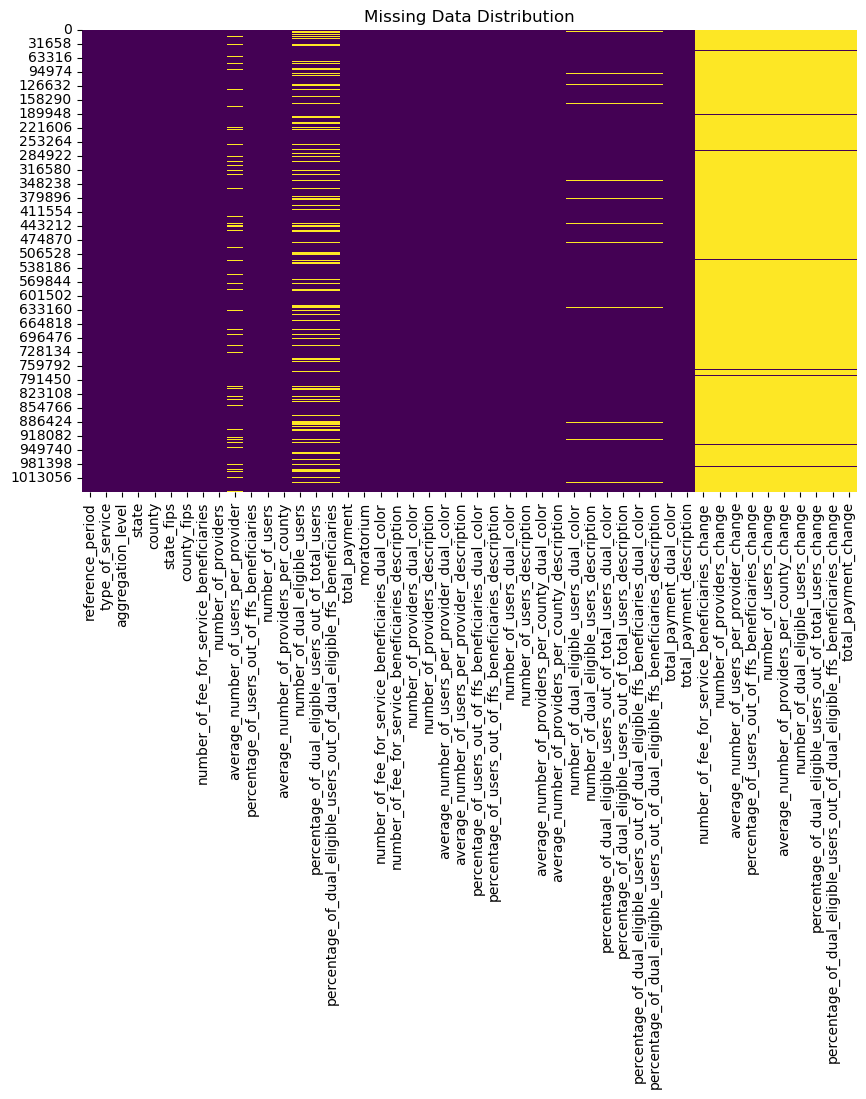

In [16]:
# plot misisng data distribution 
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Distribution')
plt.show()

There are now tons of the "missing values" - it might mean that instead of putting 0 for the input, the user left it blank. We can easily impute these values with 0s.

Let's compare the kurtosis of the numeric columns before and after imputation with 0.

In [20]:
# before imputation 
# exclude non-numeric columns
numeric_data = data.select_dtypes(include=['float', 'int'])

# kurtosis of variables before imputting
print('Kurtosis Before Replacing Missing Values with Zeros:')
numeric_data.kurtosis()

Kurtosis Before Replacing Missing Values with Zeros:


number_of_fee_for_service_beneficiaries                                             2745.319181
number_of_providers                                                                23792.802195
average_number_of_users_per_provider                                                 287.086006
percentage_of_users_out_of_ffs_beneficiaries                                           1.837552
number_of_users                                                                    13090.892832
average_number_of_providers_per_county                                               566.870967
number_of_dual_eligible_users                                                       8858.256024
percentage_of_dual_eligible_users_out_of_total_users                                   0.976728
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries               1.243945
total_payment                                                                      25831.008965
number_of_fee_for_service_beneficiaries_

In [21]:
# fill in missing values with 0's
na_df = data.copy() #create a copy of the df 
na_df.iloc[:, 38:48] = na_df.iloc[:,38:48].fillna(0)

In [22]:
# after imputation
# exclude non-numeric columns
na_numeric_data = na_df.select_dtypes(include=['float', 'int'])

# kurtosis of variables after imputting
print('Kurtosis after Replacing Missing Values with Zeros')
na_numeric_data.kurtosis()

Kurtosis after Replacing Missing Values with Zeros


number_of_fee_for_service_beneficiaries                                              2745.319181
number_of_providers                                                                 23792.802195
average_number_of_users_per_provider                                                  287.086006
percentage_of_users_out_of_ffs_beneficiaries                                            1.837552
number_of_users                                                                     13090.892832
average_number_of_providers_per_county                                                566.870967
number_of_dual_eligible_users                                                        8858.256024
percentage_of_dual_eligible_users_out_of_total_users                                    0.976728
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries                1.243945
total_payment                                                                       25831.008965
number_of_fee_for_service_bene

If we fill in the missing values with '0', it dramatically alters the kurtosis of the data features. Therefore, we should look into dropping or imputing missing variables with a more suitable method.

#### Relationships Between Features
##### Numeric Features

In [23]:
# perform correlation analysiss on numeric values 
original_corr = numeric_data.corr()
original_corr

,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_county,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,number_of_fee_for_service_beneficiaries_change,number_of_providers_change,average_number_of_users_per_provider_change,percentage_of_users_out_of_ffs_beneficiaries_change,number_of_users_change,average_number_of_providers_per_county_change,number_of_dual_eligible_users_change,percentage_of_dual_eligible_users_out_of_total_users_change,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change,total_payment_change
number_of_fee_for_service_beneficiaries,1.000000,0.513845,0.155145,0.000219,0.649375,0.062690,0.704795,-0.002298,-0.006453,0.497340,-0.031686,0.000023,-0.054474,-0.002962,-0.003272,0.002358,-0.004200,-0.042738,-0.003623,-0.004181
number_of_providers,0.513845,1.000000,0.010119,0.038329,0.704349,0.157883,0.637648,-0.018676,0.029946,0.103567,-0.020485,0.003843,-0.053660,0.000994,0.000161,0.004570,0.000032,-0.004366,0.000457,0.000157
average_number_of_users_per_provider,0.155145,0.010119,1.000000,0.233266,0.246165,0.006783,0.265996,-0.050299,0.267447,0.204741,-0.042449,-0.026557,-0.031100,-0.027672,-0.020947,-0.023990,-0.024831,-0.017866,-0.026498,-0.022904
percentage_of_users_out_of_ffs_beneficiaries,0.000219,0.038329,0.233266,1.000000,0.042516,0.276058,0.034229,-0.353973,0.943601,0.012474,-0.062967,-0.018307,-0.187509,-0.019035,-0.013405,-0.016979,-0.017955,0.012969,-0.019688,-0.013588
number_of_users,0.649375,0.704349,0.246165,0.042516,1.000000,0.098247,0.965852,-0.015108,0.039584,0.485997,-0.023925,-0.004607,-0.058637,-0.005778,-0.004662,-0.003315,-0.005798,-0.016224,-0.005864,-0.005082
average_number_of_providers_per_county,0.062690,0.157883,0.006783,0.276058,0.098247,1.000000,0.100660,-0.126048,0.224228,0.017387,-0.057415,0.016366,-0.136964,0.014203,0.009888,0.017891,0.010969,-0.030366,0.012857,0.012724
number_of_dual_eligible_users,0.704795,0.637648,0.265996,0.034229,0.965852,0.100660,1.000000,0.000184,0.037998,0.511635,-0.024591,-0.001495,-0.062250,-0.003357,-0.003168,0.000489,-0.003675,-0.035948,-0.003485,-0.003512
percentage_of_dual_eligible_users_out_of_total_users,-0.002298,-0.018676,-0.050299,-0.353973,-0.015108,-0.126048,0.000184,1.000000,-0.205008,-0.000955,0.064712,0.024949,0.088446,0.035182,0.022234,0.030057,0.041047,-0.252289,0.042523,0.021934
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,-0.006453,0.029946,0.267447,0.943601,0.039584,0.224228,0.037998,-0.205008,1.000000,0.011488,-0.058329,-0.008534,-0.189580,-0.012623,-0.008829,-0.008513,-0.012208,-0.031618,-0.014228,-0.007185
total_payment,0.497340,0.103567,0.204741,0.012474,0.485997,0.017387,0.511635,-0.000955,0.011488,1.000000,-0.018106,-0.007393,-0.032732,-0.007161,-0.005525,-0.006361,-0.007146,-0.035301,-0.006703,-0.006270


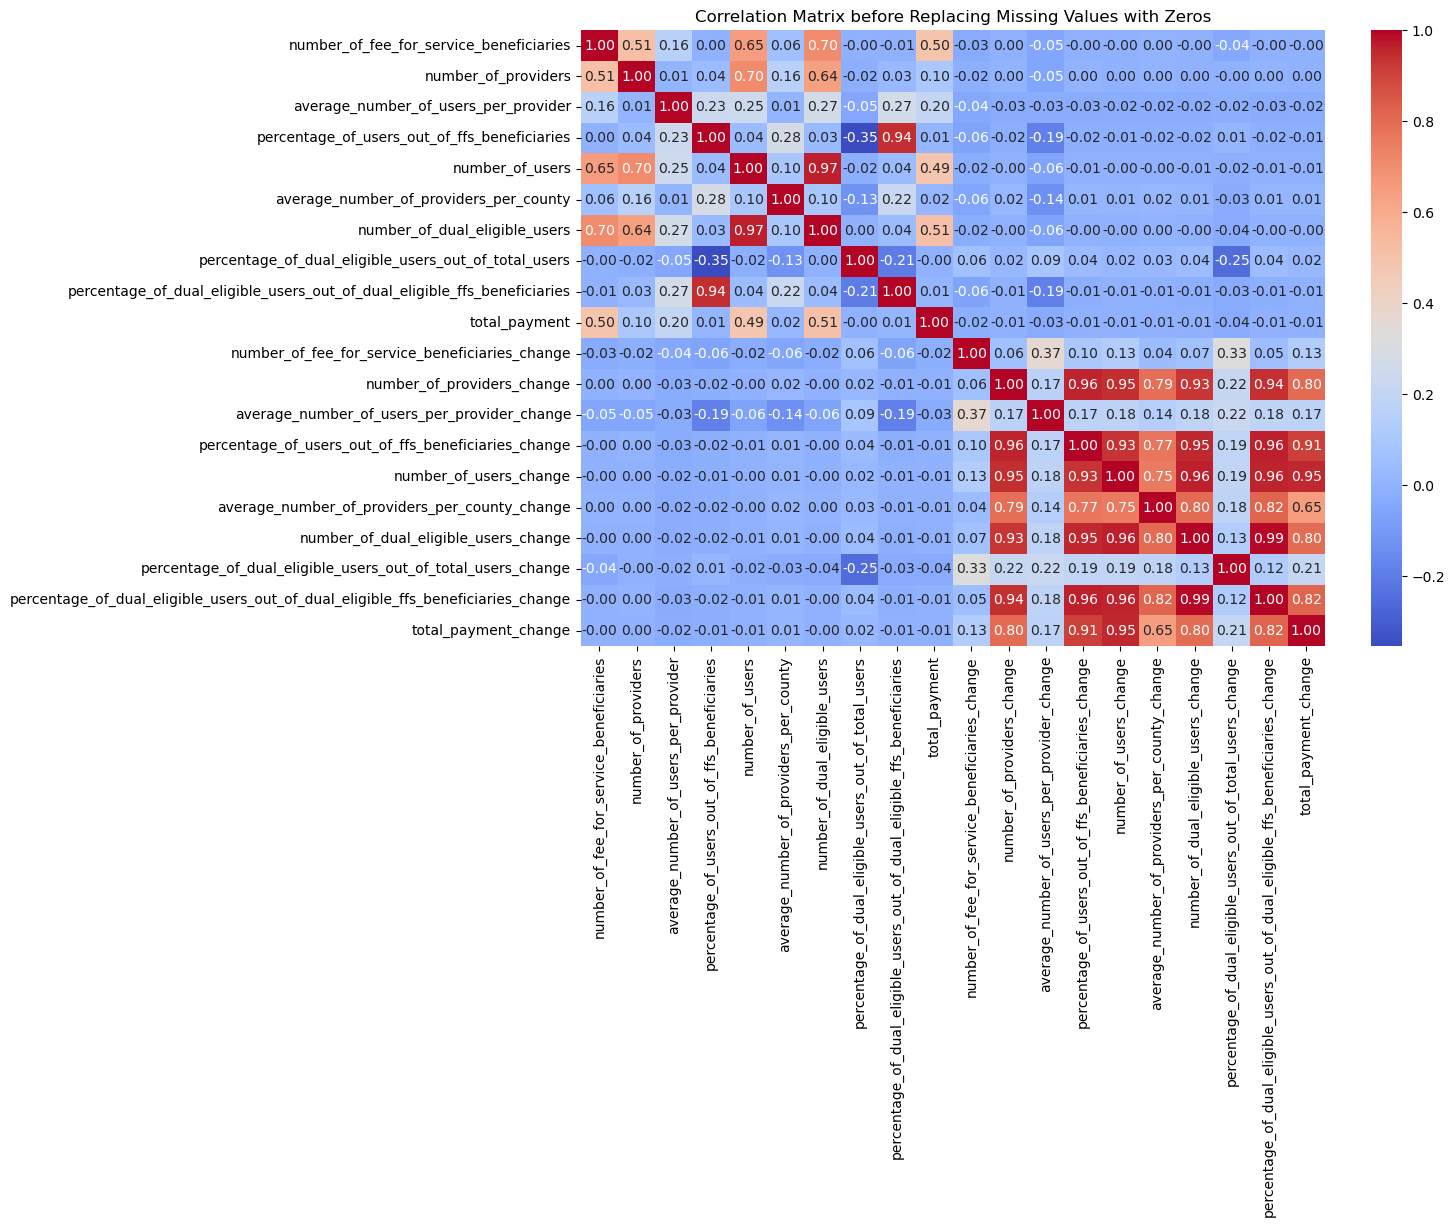

In [24]:
# visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix before Replacing Missing Values with Zeros')
plt.show()

In [25]:
# perform correlation analysis on numeric values (after imputation)
na_corr = na_numeric_data.corr()
na_corr

,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_county,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,number_of_fee_for_service_beneficiaries_change,number_of_providers_change,average_number_of_users_per_provider_change,percentage_of_users_out_of_ffs_beneficiaries_change,number_of_users_change,average_number_of_providers_per_county_change,number_of_dual_eligible_users_change,percentage_of_dual_eligible_users_out_of_total_users_change,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change,total_payment_change
number_of_fee_for_service_beneficiaries,1.000000,0.513845,0.155145,0.000219,0.649375,0.062690,0.704795,-0.002298,-0.006453,0.497340,0.120190,0.015101,0.113723,0.012825,0.008742,0.014924,0.015551,0.173432,0.012664,0.010725
number_of_providers,0.513845,1.000000,0.010119,0.038329,0.704349,0.157883,0.637648,-0.018676,0.029946,0.103567,0.060429,0.011557,0.041343,0.009109,0.006319,0.011045,0.010254,0.101813,0.008845,0.007791
average_number_of_users_per_provider,0.155145,0.010119,1.000000,0.233266,0.246165,0.006783,0.265996,-0.050299,0.267447,0.204741,0.153897,0.000935,0.161863,0.000646,0.000412,-0.000066,0.006703,0.219746,0.001734,0.002438
percentage_of_users_out_of_ffs_beneficiaries,0.000219,0.038329,0.233266,1.000000,0.042516,0.276058,0.034229,-0.353973,0.943601,0.012474,-0.009406,-0.002656,-0.021967,-0.002765,-0.001964,-0.002443,-0.002625,-0.002381,-0.002790,-0.002040
number_of_users,0.649375,0.704349,0.246165,0.042516,1.000000,0.098247,0.965852,-0.015108,0.039584,0.485997,0.074444,0.005565,0.055988,0.004738,0.003288,0.005286,0.007179,0.117419,0.004932,0.004703
average_number_of_providers_per_county,0.062690,0.157883,0.006783,0.276058,0.098247,1.000000,0.100660,-0.126048,0.224228,0.017387,0.036811,0.009537,0.023532,0.009086,0.006631,0.009176,0.009576,0.063165,0.008904,0.008341
number_of_dual_eligible_users,0.704795,0.637648,0.265996,0.034229,0.965852,0.100660,1.000000,0.000184,0.037998,0.511635,0.094048,0.009231,0.064728,0.007777,0.005278,0.009473,0.010074,0.117124,0.007879,0.006898
percentage_of_dual_eligible_users_out_of_total_users,-0.002298,-0.018676,-0.050299,-0.353973,-0.015108,-0.126048,0.000184,1.000000,-0.205008,-0.000955,-0.007694,0.001924,-0.004926,0.003248,0.001887,0.002799,0.003681,-0.037679,0.004183,0.001599
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,-0.006453,0.029946,0.267447,0.943601,0.039584,0.224228,0.037998,-0.205008,1.000000,0.011488,-0.024050,-0.002883,-0.037850,-0.003492,-0.002537,-0.002630,-0.003840,-0.024604,-0.003743,-0.002619
total_payment,0.497340,0.103567,0.204741,0.012474,0.485997,0.017387,0.511635,-0.000955,0.011488,1.000000,0.056807,0.000776,0.051151,0.001155,0.000749,0.000601,0.003048,0.077042,0.001776,0.001448


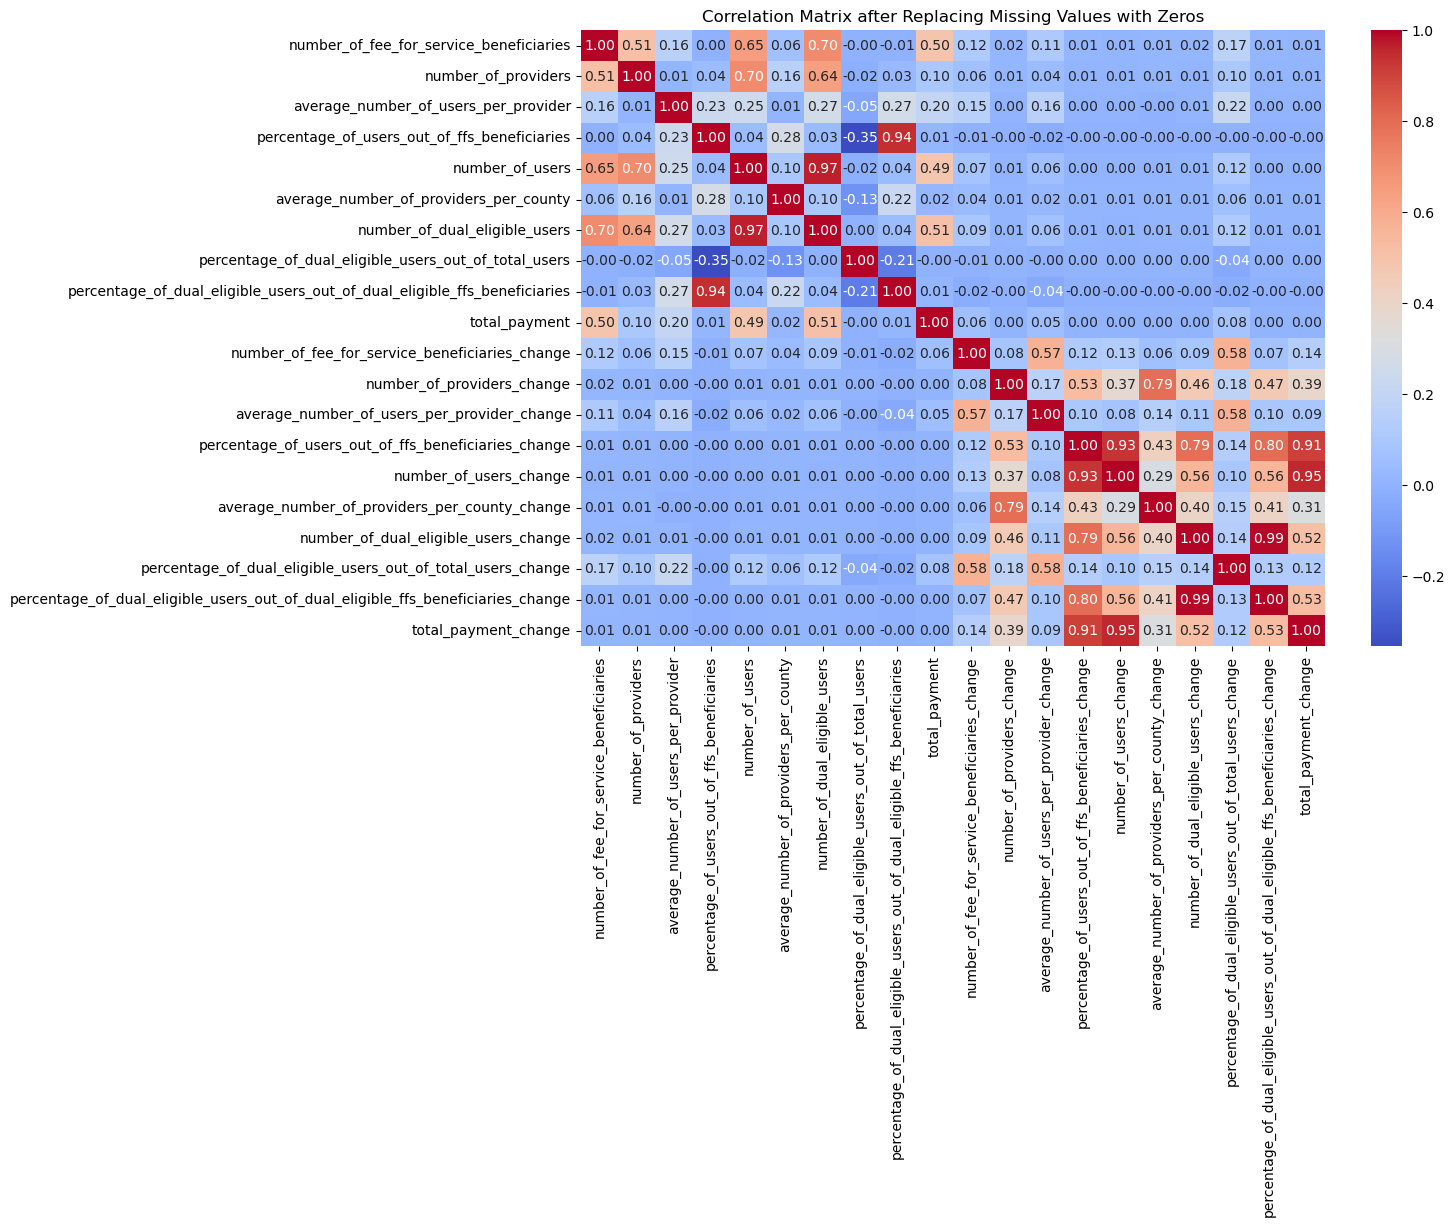

In [26]:
# visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(na_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix after Replacing Missing Values with Zeros')
plt.show()

Introducing zeros can distort the relationships between variables, leading to incorrect insights. Thus, imputing missing values with zero is likely to distort the data's relationships and lead to misleading results.

We will look into dropping columns with more than 50% missing values and imputing the remaining missing values.

In [27]:
# drop columns that are missing 50% or more data 
# Calculate percentage of missing values for each column
missing_percentages = (data.isnull().sum() / len(data)) * 100

# Create a boolean mask for columns with more than 50% missing data
columns_to_drop = missing_percentages[missing_percentages > 50].index

# Drop columns from the DataFrame without inplace=True
data = data.drop(columns=columns_to_drop)

data.head()

,reference_period,type_of_service,aggregation_level,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,...,average_number_of_providers_per_county_dual_color,average_number_of_providers_per_county_description,number_of_dual_eligible_users_dual_color,number_of_dual_eligible_users_description,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_description,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_description,total_payment_dual_color,total_payment_description
0,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,,,36122263.0,8814.0,495.69,...,,,,,,,,,,
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AL,--ALL--,01,,547486.0,146.0,501.47,...,BLUE 2,Second Lowest 25 7.10 - 15.11 Providers,BLUE 3,Third Lowest 25 14276 - 31537 Dual Eligible Users,BLUE 4,Top 25 Excl. Extreme Values 33.61 - 49.85 of T...,BLUE 3,Third Lowest 25 19.99 - 22.03 of Total FFS Ben...,BLUE 3,Third Lowest 25 $49345636.69 - $106424718.18
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AK,--ALL--,02,,91480.0,33.0,254.97,...,BLUE 1,Lowest 25 Less than 7.10 Providers,BLUE 1,Lowest 25 Less than 4833 Dual Eligible Users,BLUE 4,Top 25 Excl. Extreme Values 33.61 - 49.85 of T...,BLUE 2,Second Lowest 25 17.37 - 19.98 of Total FFS Be...,BLUE 1,Lowest 25 Less than $13090494.20
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AZ,--ALL--,04,,740278.0,170.0,401.34,...,BLUE 4,Top 25 Excl. Extreme Values 37.53 - 83.16 Prov...,BLUE 2,Second Lowest 25 4833 - 14275 Dual Eligible Users,BLUE 1,Lowest 25 Less than 22.78 of Total Users,BLUE 1,Lowest 25 Less than 17.37 of Total FFS Benefic...,BLUE 2,Second Lowest 25 $13090494.20 - $49345636.68
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AR,--ALL--,05,,437616.0,86.0,628.07,...,BLUE 2,Second Lowest 25 7.10 - 15.11 Providers,NaN,NaN,NaN,NaN,NaN,NaN,BLUE 3,Third Lowest 25 $49345636.69 - $106424718.18


In [28]:
# first row appears to be a missing a majority of its values -  remove row instead of replacing for data integrity 
data.drop(data.index[0], inplace=True)

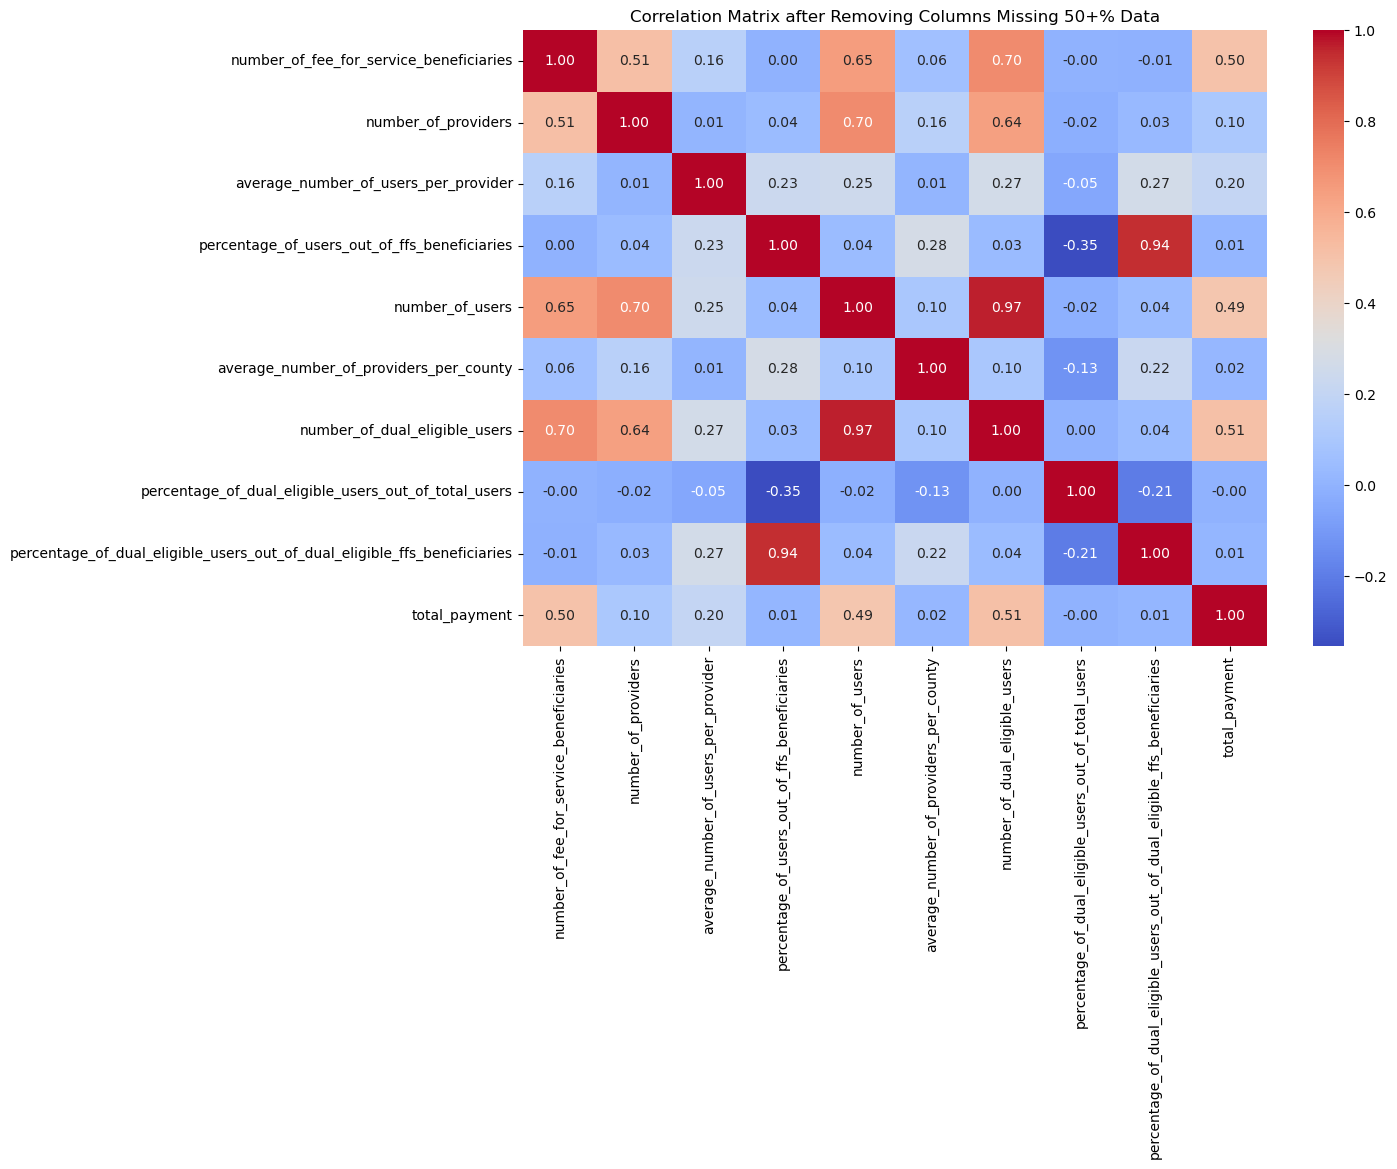

In [29]:
# perform correlation analysis on numeric values 
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

# visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix after Removing Columns Missing 50+% Data')
plt.show()

There's still a few features that are highly correlated so we're going to remove them.

In [30]:
# Drop columns that are still highly correlated in the correlation matrix
data = data.drop(columns = ['percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
                                            'number_of_dual_eligible_users'])

In [31]:
# drop columns that provided descriptions of the column - they are redundant
data = data.drop(columns = ['aggregation_level','number_of_fee_for_service_beneficiaries_description',
                                       'number_of_providers_description','average_number_of_users_per_provider_description',
                                       'percentage_of_users_out_of_ffs_beneficiaries_description',
                                       'number_of_users_description',
                                       'average_number_of_providers_per_county_description',
                                       'number_of_dual_eligible_users_description',
                                       'percentage_of_dual_eligible_users_out_of_total_users_description',
                                       'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_description',
                                       'total_payment_description'])

#### Handling Missing Values 

In [33]:
# Count how many missing values are remaining (NaNs) for each column (should be columns with less than 50% misisng data)
na_counts = data.isna().sum()
total_records = len(data)
percentage_na = (na_counts / total_records)

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Percentage': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

print("DataFrame with counts of NaN values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='fancy_grid'))

DataFrame with counts of NaN values:
╒════╤═════════════════════════════════════════════════════════════════════════════════════╤═════════════════╤══════════════╕
│    │ Column                                                                              │   Missing Count │   Percentage │
╞════╪═════════════════════════════════════════════════════════════════════════════════════╪═════════════════╪══════════════╡
│  0 │ reference_period                                                                    │               0 │    0         │
├────┼─────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  1 │ type_of_service                                                                     │               0 │    0         │
├────┼─────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  2 │ state                                                                     

In [34]:
# impute missing variables using mode
for column in data.columns:
    mode_value = data[column].mode()[0]  # Calculate mode
    data[column] = data[column].fillna(mode_value)  # Impute mode and assign back to the column

In [35]:
# double check missing percentage to ensure appropriate columns were removed and imputed 
missing_percentages = (data.isnull().sum() / len(data)) * 100
missing_percentages

reference_period                                                                       0.0
type_of_service                                                                        0.0
state                                                                                  0.0
county                                                                                 0.0
state_fips                                                                             0.0
county_fips                                                                            0.0
number_of_fee_for_service_beneficiaries                                                0.0
number_of_providers                                                                    0.0
average_number_of_users_per_provider                                                   0.0
percentage_of_users_out_of_ffs_beneficiaries                                           0.0
number_of_users                                                                        0.0

## Visualizations

In [36]:
# Define numeric data
numeric_data = data.select_dtypes(include=['float', 'int']) #select only float64 columns
numeric_data_columns = numeric_data.columns.tolist()  
print("Numeric Data Columns:")
print(numeric_data_columns)
print()

# Define categorical data
cat_data = data.select_dtypes(include=['object'])  # select only object (string) columns
cat_data_columns = cat_data.columns.tolist() 
print("Categorical Data Columns:")
print(cat_data_columns)
print()

Numeric Data Columns:
['number_of_fee_for_service_beneficiaries', 'number_of_providers', 'average_number_of_users_per_provider', 'percentage_of_users_out_of_ffs_beneficiaries', 'number_of_users', 'average_number_of_providers_per_county', 'percentage_of_dual_eligible_users_out_of_total_users', 'total_payment']

Categorical Data Columns:
['reference_period', 'type_of_service', 'state', 'county', 'state_fips', 'county_fips', 'moratorium', 'number_of_fee_for_service_beneficiaries_dual_color', 'number_of_providers_dual_color', 'average_number_of_users_per_provider_dual_color', 'percentage_of_users_out_of_ffs_beneficiaries_dual_color', 'number_of_users_dual_color', 'average_number_of_providers_per_county_dual_color', 'number_of_dual_eligible_users_dual_color', 'percentage_of_dual_eligible_users_out_of_total_users_dual_color', 'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color', 'total_payment_dual_color']



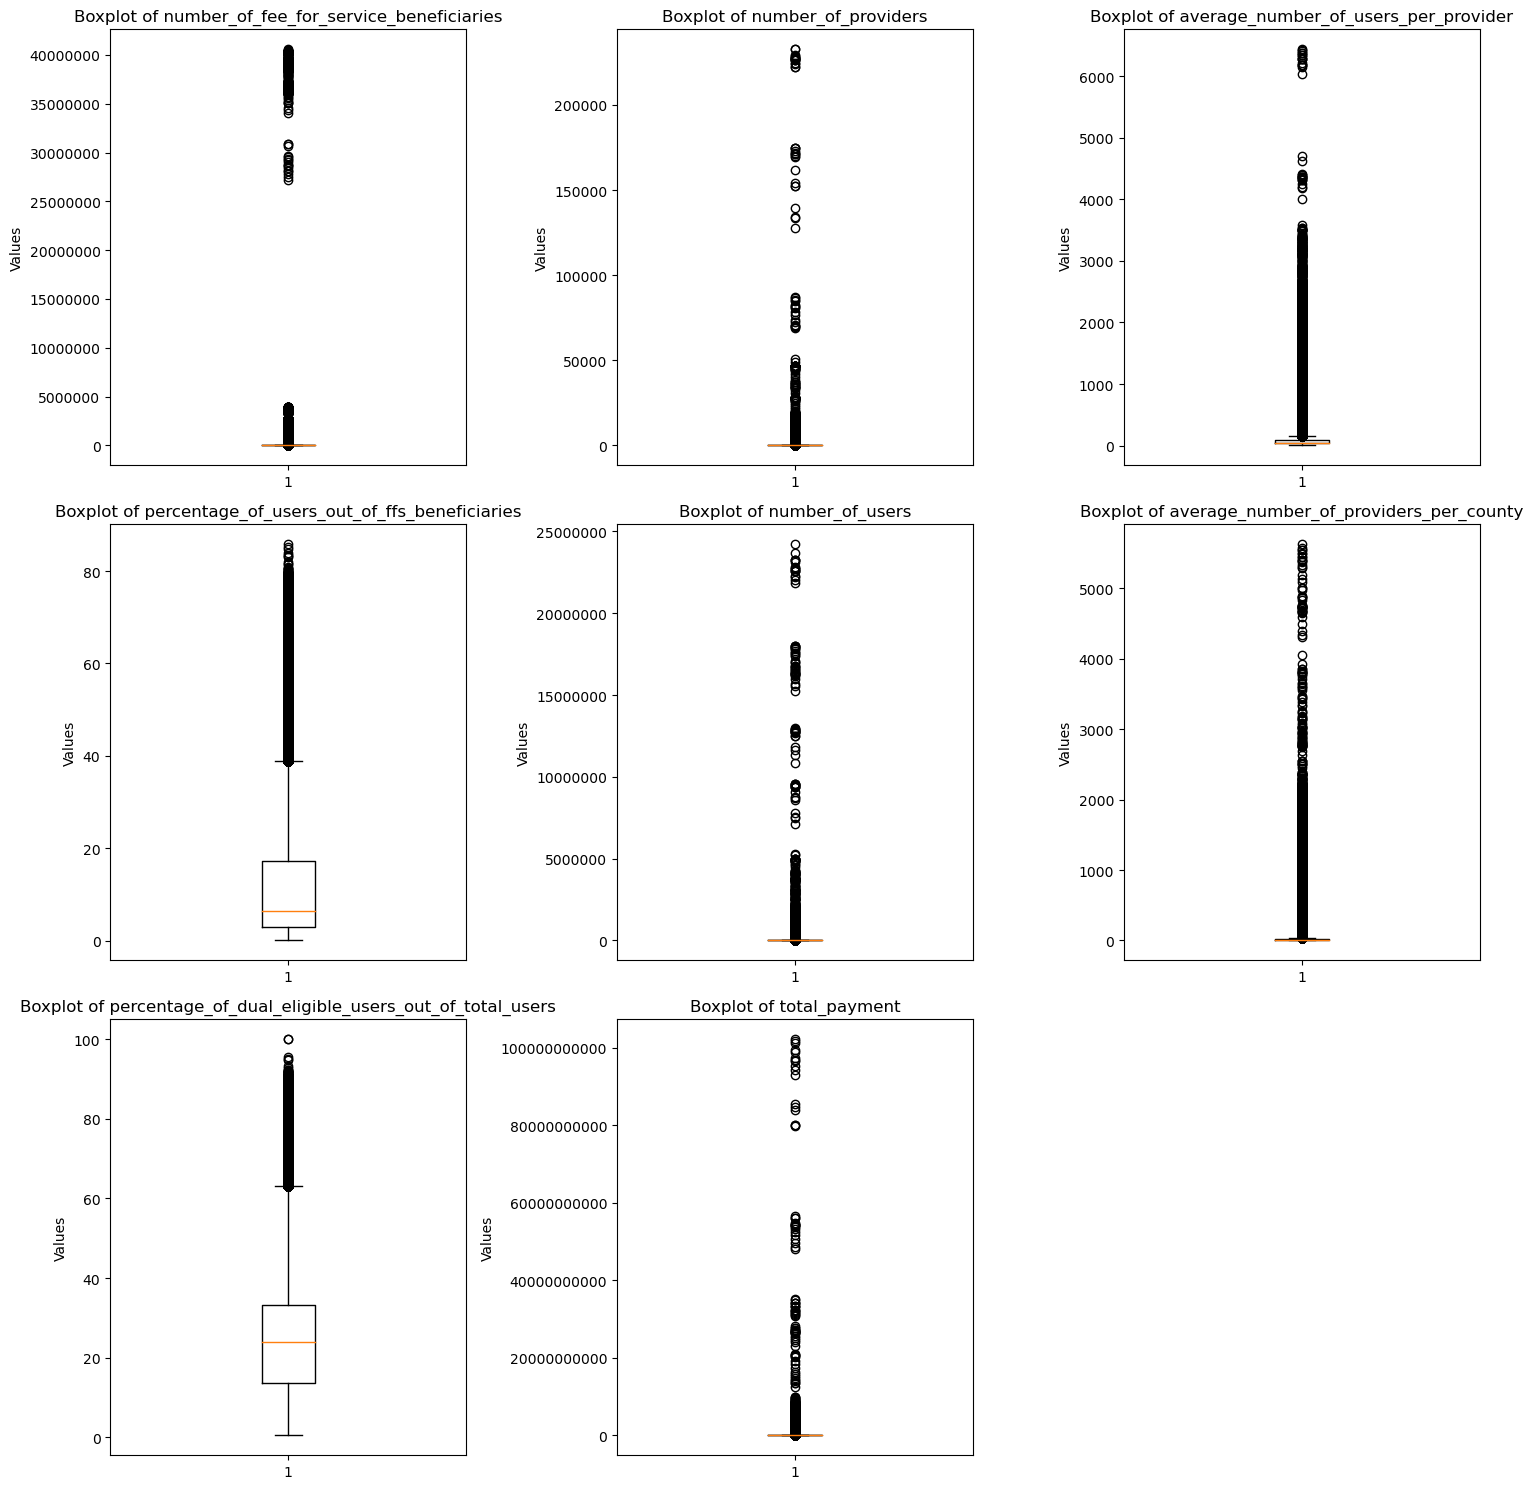

In [37]:
# get number of columns in numeric_data
num_columns = len(numeric_data.columns)

# calculate the number of rows and columns needed for the subplot grid
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
#flatten the axes array 
axes = axes.flatten()

# plotboxplots for numerical columns 
for i, column in enumerate(numeric_data.columns):
    axes[i].boxplot(numeric_data[column].dropna())
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel('Values')
    axes[i].ticklabel_format(style='plain', axis='y')
    

# hide empty subplots if there are more axes than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are a lot of outliers due to the nature of this data. So, we are keeping all the outliers.

This decision ensures that we capture and analyze the full range of data points, including those that significantly deviate from the typical distribution.

#### *Histograms before boxcox transformation*

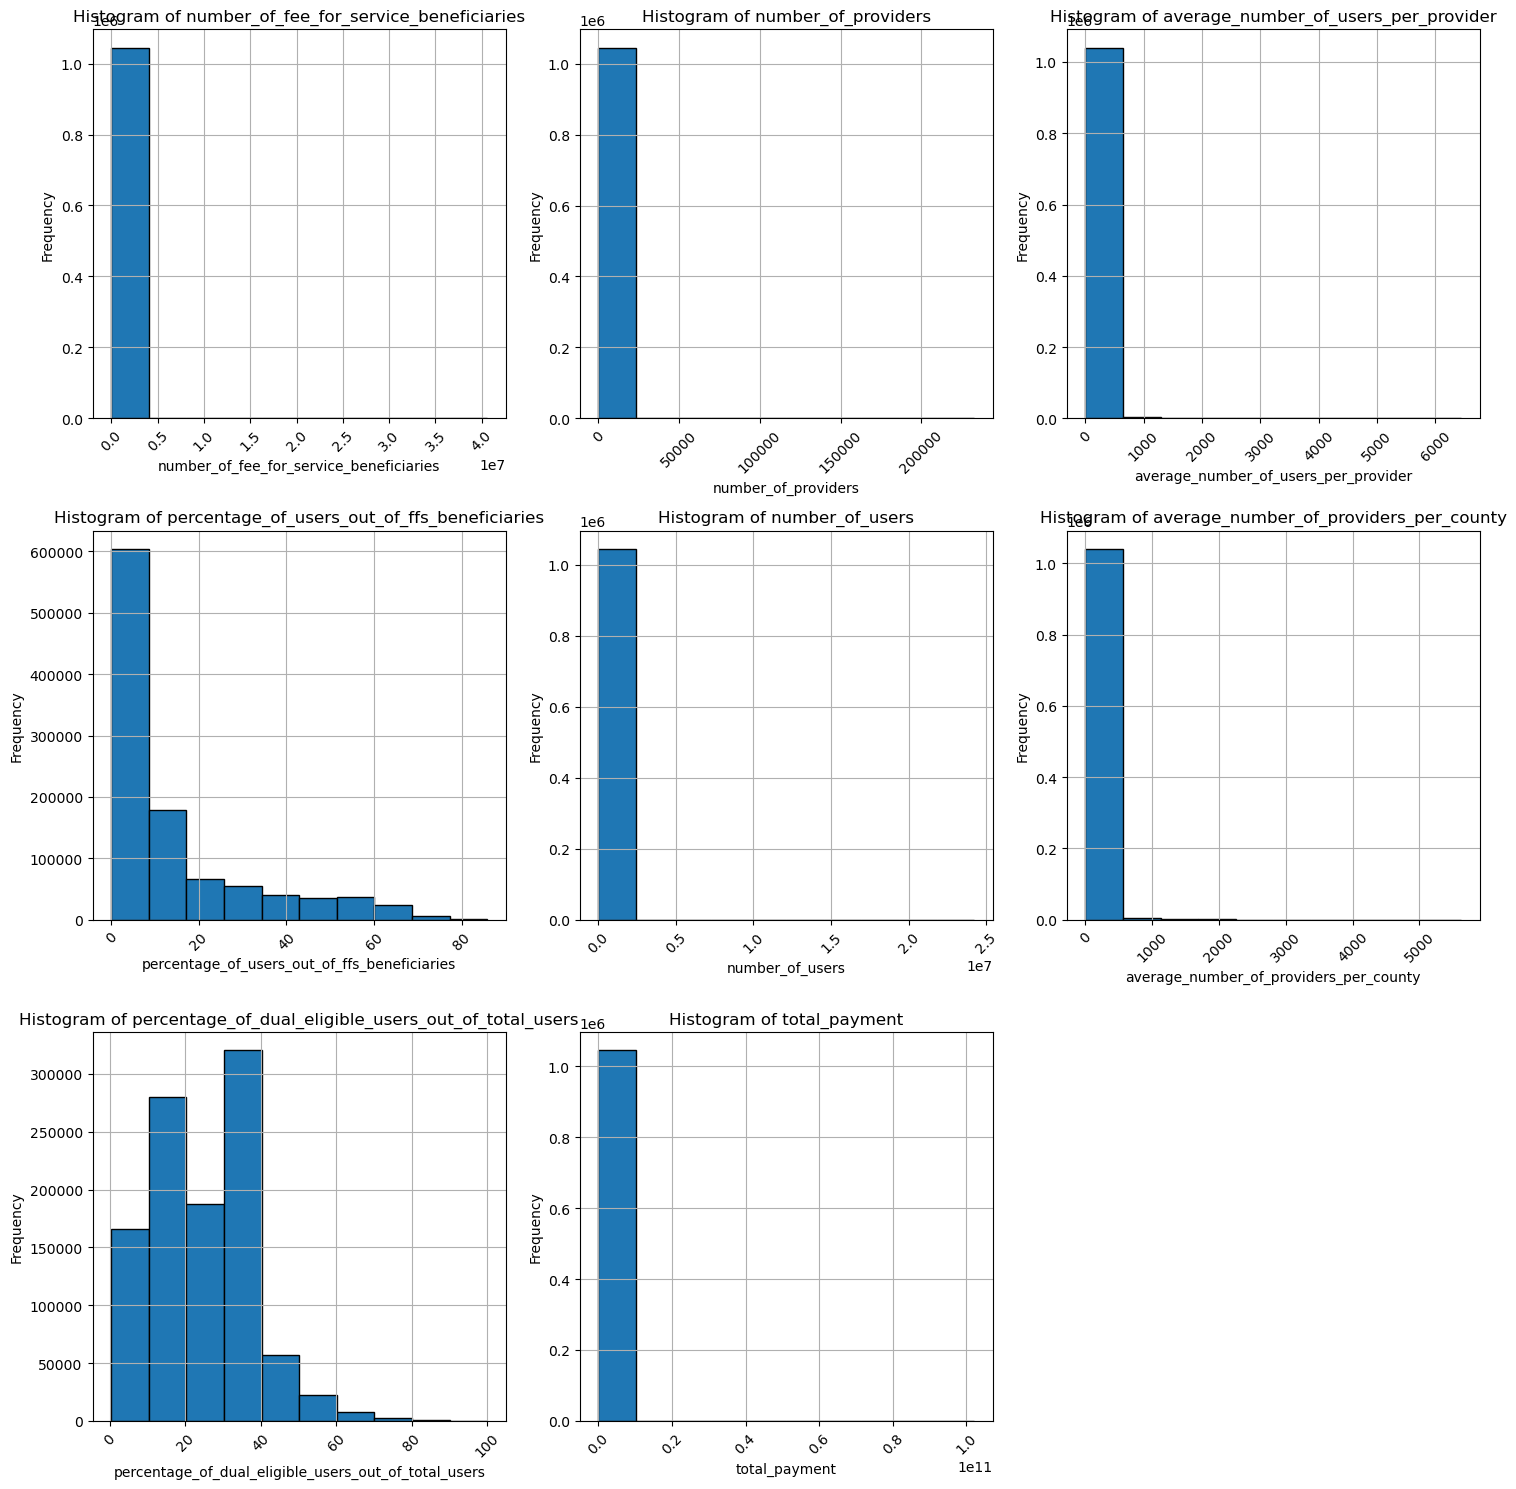

In [38]:
# get number of columns in numeric_data
num_columns = len(numeric_data.columns)

# calculate the number of rows and columns needed for the subplot grid
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot histograms for each column using Matplotlib
for i, column in enumerate(numeric_data.columns):
    ax = axes[i]
    ax.hist(numeric_data[column], bins=10, edgecolor='black') 
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)  # Add grid for better visibility

# hide empty subplots if there are more axes than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### *Histograms after boxcox transformation*

In [39]:
# create copy of df 
data_transformed = data.copy()
# Function to apply Box-Cox transformation
def boxcox_transform(column):
    # Shift data if necessary to ensure all values are positive
    min_val = column.min()
    if min_val <= 0:
        column = column - min_val + 1
    transformed_col, _ = stats.boxcox(column)
    return transformed_col

# Apply Box-Cox transformation to each numeric column
for col in numeric_data_columns:
    data_transformed[col] = boxcox_transform(data_transformed[col])

# Display the transformed data
data_transformed.head()

,reference_period,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,...,number_of_fee_for_service_beneficiaries_dual_color,number_of_providers_dual_color,average_number_of_users_per_provider_dual_color,percentage_of_users_out_of_ffs_beneficiaries_dual_color,number_of_users_dual_color,average_number_of_providers_per_county_dual_color,number_of_dual_eligible_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,total_payment_dual_color
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AL,--ALL--,01,,5.637719,3.049076,2.690308,2.956496,...,BLUE 3,BLUE 2,BLUE 4,BLUE 4,BLUE 3,BLUE 2,BLUE 3,BLUE 4,BLUE 3,BLUE 3
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AK,--ALL--,02,,5.369383,2.465080,2.587809,2.482044,...,BLUE 1,BLUE 1,BLUE 2,BLUE 2,BLUE 1,BLUE 1,BLUE 1,BLUE 4,BLUE 2,BLUE 1
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AZ,--ALL--,04,,5.676107,3.099500,2.658982,2.484749,...,BLUE 3,BLUE 3,BLUE 3,BLUE 2,BLUE 3,BLUE 4,BLUE 2,BLUE 1,BLUE 1,BLUE 2
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AR,--ALL--,05,,5.608039,2.860802,2.719769,2.853260,...,BLUE 2,BLUE 2,BLUE 4,BLUE 3,BLUE 3,BLUE 2,BLUE 1,BLUE 1,BLUE 1,BLUE 3
5,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),CA,--ALL--,06,,5.845642,3.301326,2.790851,2.737442,...,BLUE 5,BLUE 4,BLUE 5,BLUE 2,BLUE 5,BLUE 4,BLUE 5,BLUE 4,BLUE 2,BLUE 5


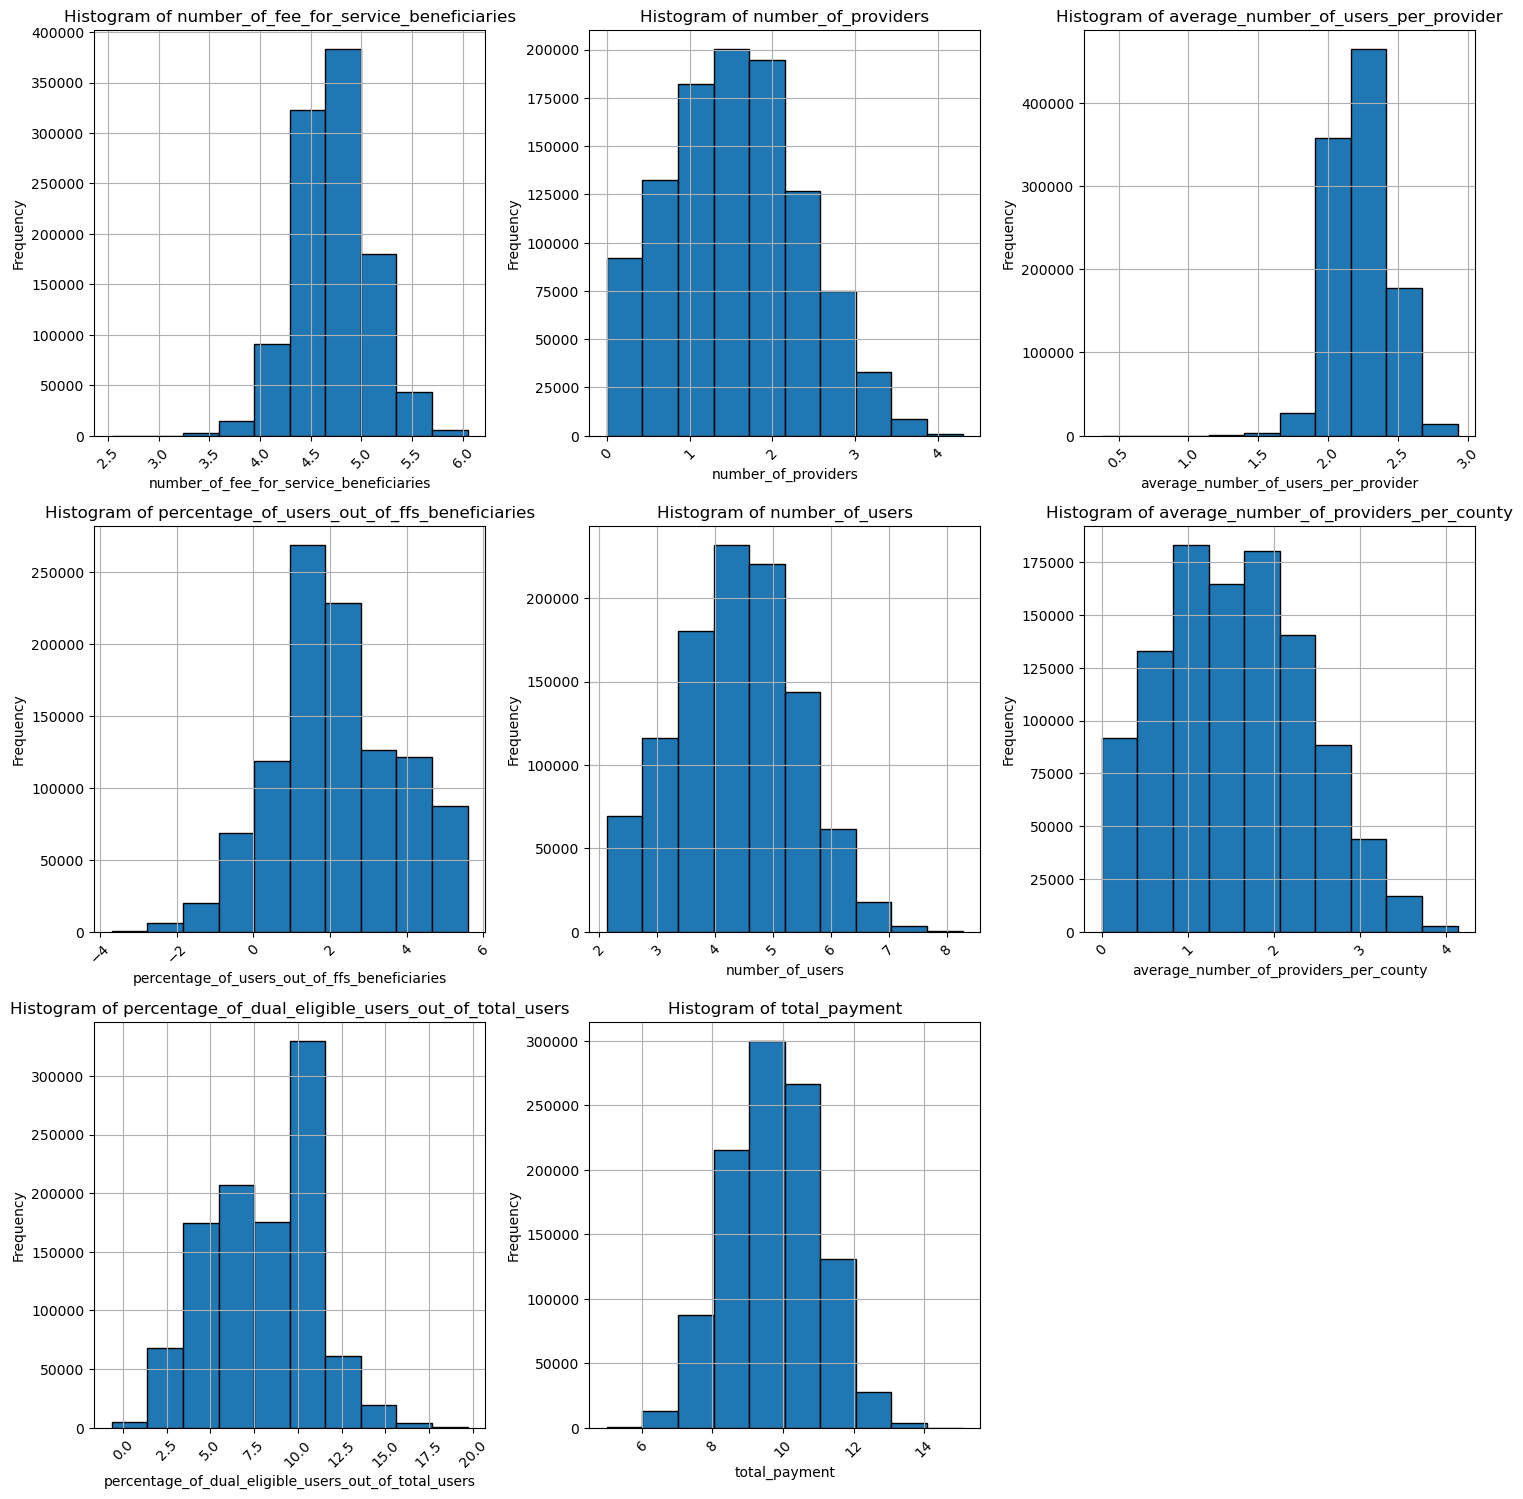

In [40]:
# get numeric columns
numeric_columns = data_transformed.select_dtypes(include=['float', 'int']).columns

# calculate the number of rows and columns needed for the subplot grid
num_columns = len(numeric_columns)
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# flatten the axes array to simplify indexing
axes = axes.flatten()

# plot histograms for each column using Matplotlib
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    ax.hist(data_transformed[column], bins=10, edgecolor='black') 
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)  # Add grid for better visibility

# hide empty subplots if there are more axes than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [41]:
scaler = StandardScaler()
# Apply standardization to each numeric column
data_transformed[numeric_columns] = scaler.fit_transform(data_transformed[numeric_columns])

In [42]:
data_transformed.head()

,reference_period,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,...,number_of_fee_for_service_beneficiaries_dual_color,number_of_providers_dual_color,average_number_of_users_per_provider_dual_color,percentage_of_users_out_of_ffs_beneficiaries_dual_color,number_of_users_dual_color,average_number_of_providers_per_county_dual_color,number_of_dual_eligible_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,total_payment_dual_color
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AL,--ALL--,01,,2.528345,1.811786,2.347850,0.491848,...,BLUE 3,BLUE 2,BLUE 4,BLUE 4,BLUE 3,BLUE 2,BLUE 3,BLUE 4,BLUE 3,BLUE 3
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AK,--ALL--,02,,1.785117,1.113930,1.809674,0.194710,...,BLUE 1,BLUE 1,BLUE 2,BLUE 2,BLUE 1,BLUE 1,BLUE 1,BLUE 4,BLUE 2,BLUE 1
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AZ,--ALL--,04,,2.634669,1.872041,2.183375,0.196405,...,BLUE 3,BLUE 3,BLUE 3,BLUE 2,BLUE 3,BLUE 4,BLUE 2,BLUE 1,BLUE 1,BLUE 2
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AR,--ALL--,05,,2.446139,1.586804,2.502539,0.427194,...,BLUE 2,BLUE 2,BLUE 4,BLUE 3,BLUE 3,BLUE 2,BLUE 1,BLUE 1,BLUE 1,BLUE 3
5,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),CA,--ALL--,06,,3.104244,2.113215,2.875760,0.354660,...,BLUE 5,BLUE 4,BLUE 5,BLUE 2,BLUE 5,BLUE 4,BLUE 5,BLUE 4,BLUE 2,BLUE 5


In [43]:
# summary statistics
numeric_data.describe()

,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_county,percentage_of_dual_eligible_users_out_of_total_users,total_payment
count,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06
mean,3.879750e+04,4.590741e+01,8.135521e+01,1.383453e+01,5.394286e+03,2.397508e+01,2.439207e+01,1.289917e+07
std,7.156326e+05,1.233758e+03,1.170855e+02,1.673264e+01,1.552258e+05,9.465588e+01,1.283742e+01,4.817444e+08
min,2.500000e+01,0.000000e+00,1.500000e+00,1.000000e-02,1.100000e+01,0.000000e+00,4.700000e-01,2.913100e+02
25%,2.203000e+03,2.000000e+00,3.400000e+01,2.910000e+00,9.200000e+01,2.000000e+00,1.354000e+01,7.729715e+04
50%,4.543000e+03,5.000000e+00,4.952000e+01,6.470000e+00,3.140000e+02,5.000000e+00,2.388000e+01,3.756805e+05
75%,1.192600e+04,1.600000e+01,8.500000e+01,1.730000e+01,1.171000e+03,1.600000e+01,3.333000e+01,1.981957e+06
max,4.058377e+07,2.327730e+05,6.440620e+03,8.583000e+01,2.422417e+07,5.625000e+03,1.000000e+02,1.021595e+11


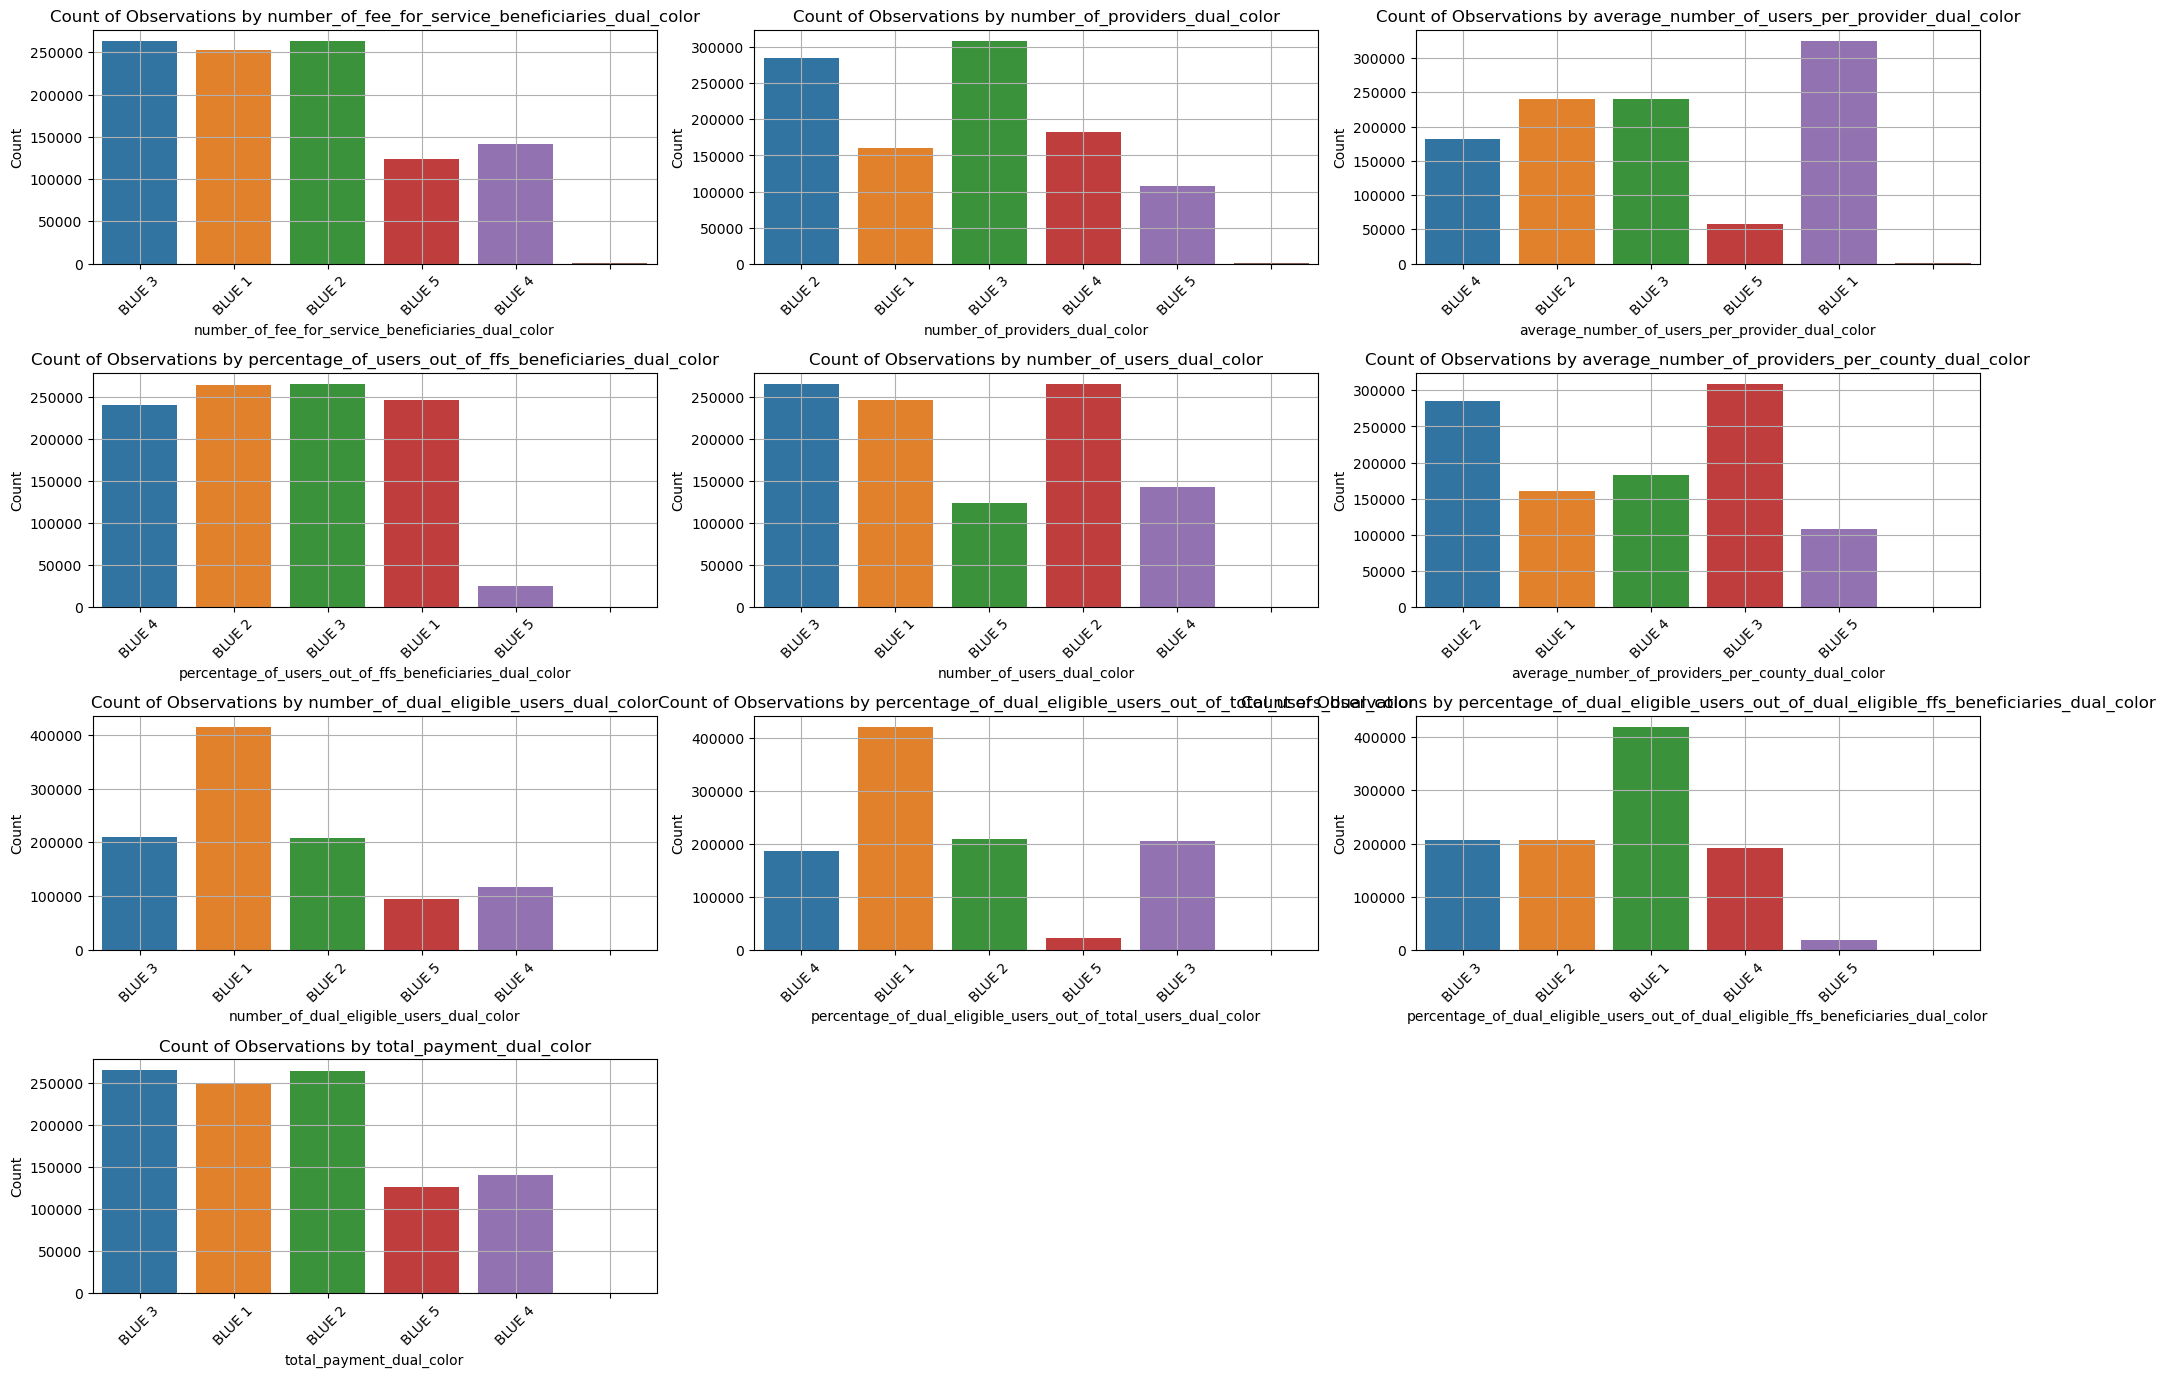

In [44]:
#get number of columns in categorical data 
num_columns = len(cat_data.columns)

# calculate number of rows and columns needed for the subplot grid
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# flatten the axes array to simplify indexing
axes = axes.flatten()

# plotting count plots for each categorical column
categorical_columns = cat_data.iloc[:, 7:].select_dtypes(include=['object']).columns
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=cat_data, ax=axes[i])
    axes[i].set_title(f'Count of Observations by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# hide empty subplots if there are more axes than needed
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])
        
plt.tight_layout() 
plt.show()

However, for our current data analysis and modeling purposes, we focus exclusively on the numeric values within these columns. The presence of 'BLUE' does not contribute to numerical computations and statistical analyses, which require consistent numeric formats across datasets.

Therefore, by removing 'BLUE' from each element in these columns using the following Python code:

In [45]:
df = data.copy() #create a copy of the df to work on 

In [46]:
# Remove 'BLUE' from each element in the relevant columns
for column in df.columns[15:]:  
    df[column] = df[column].astype(str).str.replace('BLUE', '').str.strip()
    df[column] = pd.to_numeric(df[column], errors='coerce')

#drop any NA values created during the process 
df.dropna(subset=df.columns[15:], inplace=True)
    
df[df.columns[15:]] = df[df.columns[15:]].astype(int)

In [47]:
# do the same for the transformed numeric data
for column in data_transformed.columns[15:]:  
    data_transformed[column] = data_transformed[column].astype(str).str.replace('BLUE', '').str.strip()
    data_transformed[column] = pd.to_numeric(data_transformed[column], errors='coerce')

#drop any NA values created during the process 
data_transformed.dropna(subset=data_transformed.columns[15:], inplace=True)
    
data_transformed[data_transformed.columns[15:]] = data_transformed[data_transformed.columns[15:]].astype(int)

In [48]:
df.head(5) #ensure 'BLUE' was removed from the appropriate columns 

,reference_period,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,...,number_of_fee_for_service_beneficiaries_dual_color,number_of_providers_dual_color,average_number_of_users_per_provider_dual_color,percentage_of_users_out_of_ffs_beneficiaries_dual_color,number_of_users_dual_color,average_number_of_providers_per_county_dual_color,number_of_dual_eligible_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,total_payment_dual_color
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AL,--ALL--,01,,547486.0,146.0,501.47,13.37,...,3,2,4,4,3,2,3,4,3,3
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AK,--ALL--,02,,91480.0,33.0,254.97,9.20,...,1,1,2,2,1,1,1,4,2,1
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AZ,--ALL--,04,,740278.0,170.0,401.34,9.22,...,3,3,3,2,3,4,2,1,1,2
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AR,--ALL--,05,,437616.0,86.0,628.07,12.34,...,2,2,4,3,3,2,1,1,1,3
5,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),CA,--ALL--,06,,3423285.0,330.0,1169.09,11.27,...,5,4,5,2,5,4,5,4,2,5


In [49]:
data_transformed.head()

,reference_period,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,...,number_of_fee_for_service_beneficiaries_dual_color,number_of_providers_dual_color,average_number_of_users_per_provider_dual_color,percentage_of_users_out_of_ffs_beneficiaries_dual_color,number_of_users_dual_color,average_number_of_providers_per_county_dual_color,number_of_dual_eligible_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,total_payment_dual_color
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AL,--ALL--,01,,2.528345,1.811786,2.347850,0.491848,...,3,2,4,4,3,2,3,4,3,3
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AK,--ALL--,02,,1.785117,1.113930,1.809674,0.194710,...,1,1,2,2,1,1,1,4,2,1
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AZ,--ALL--,04,,2.634669,1.872041,2.183375,0.196405,...,3,3,3,2,3,4,2,1,1,2
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AR,--ALL--,05,,2.446139,1.586804,2.502539,0.427194,...,2,2,4,3,3,2,1,1,1,3
5,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),CA,--ALL--,06,,3.104244,2.113215,2.875760,0.354660,...,5,4,5,2,5,4,5,4,2,5


In [53]:
data.shape #original df shape 

(1044710, 25)

In [50]:
df.shape # new df shape 

(1044354, 25)

In [52]:
data_transformed.shape #transformed df shap

(1044354, 25)

#### Duplicate Values 

In [54]:
# check for duplicates
print('Number of Duplicated Rows:')
df.duplicated().sum() #original df is 1044710 rows 

Number of Duplicated Rows:


0

### Feature Selection

#### Target Variable 

A target variable, `potential_fwa`, was created to identify potential cases of fraud, waste, and abuse (FWA) in healthcare service utilization data. It was derived by applying logical conditions based on anomalies in `number_of_fee_for_service_beneficiaries_dual_color` and unusually high `total_payment_dual_color` values, aiming to flag instances warranting further investigation for potential fraudulent activities.

In [55]:
# print summary statistics for two columns 
print(df['number_of_fee_for_service_beneficiaries'].describe())
print(df['total_payment_dual_color'].describe())

count    1.044354e+06
mean     2.586350e+04
std      1.389055e+05
min      2.500000e+01
25%      2.203000e+03
50%      4.541000e+03
75%      1.190600e+04
max      3.897705e+06
Name: number_of_fee_for_service_beneficiaries, dtype: float64
count    1.044354e+06
mean     2.644667e+00
std      1.302929e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: total_payment_dual_color, dtype: float64


In [56]:
# define conditions for potential FWA
condition_blue = df['number_of_fee_for_service_beneficiaries_dual_color'].isin([4, 5])  # Adjust as needed based on data exploration
condition_payment = df['total_payment_dual_color'] > (df['total_payment_dual_color'].mean() + 2 * df['total_payment_dual_color'].std())

# create the 'potential_fwa' column
df['potential_fwa'] = np.where(condition_blue | condition_payment, 1, 0)

# print sample to verify
print(df[['number_of_fee_for_service_beneficiaries_dual_color', 'total_payment_dual_color', 'potential_fwa']].head(10))

    number_of_fee_for_service_beneficiaries_dual_color  \
1                                                   3    
2                                                   1    
3                                                   3    
4                                                   2    
5                                                   5    
6                                                   3    
7                                                   2    
8                                                   1    
9                                                   1    
10                                                  5    

    total_payment_dual_color  potential_fwa  
1                          3              0  
2                          1              0  
3                          2              0  
4                          3              0  
5                          5              1  
6                          2              0  
7                          3           

In [57]:
# define conditions for potential FWA
condition_blue = data_transformed['number_of_fee_for_service_beneficiaries_dual_color'].isin([4, 5])  # Adjust as needed based on data exploration
condition_payment = data_transformed['total_payment_dual_color'] > (data_transformed['total_payment_dual_color'].mean() + 2 * data_transformed['total_payment_dual_color'].std())

# create the 'potential_fwa' column
data_transformed['potential_fwa'] = np.where(condition_blue | condition_payment, 1, 0)

# print sample to verify
print(data_transformed[['number_of_fee_for_service_beneficiaries_dual_color', 'total_payment_dual_color', 'potential_fwa']].head(10))

    number_of_fee_for_service_beneficiaries_dual_color  \
1                                                   3    
2                                                   1    
3                                                   3    
4                                                   2    
5                                                   5    
6                                                   3    
7                                                   2    
8                                                   1    
9                                                   1    
10                                                  5    

    total_payment_dual_color  potential_fwa  
1                          3              0  
2                          1              0  
3                          2              0  
4                          3              0  
5                          5              1  
6                          2              0  
7                          3           

In [58]:
# print value counts 
fwa_counts = df['potential_fwa'].value_counts()
fwa_counts

potential_fwa
0    778874
1    265480
Name: count, dtype: int64

#### Chi-Square before transformations

In [59]:
# define target column to be analyzed for assocation 
target_column = 'potential_fwa'

# create an empty array to store the results of chi-square test
chi_results = []

# iterate through all columns (excluding the target column)
for column in df.columns:
    if column != target_column:
        # create a contingency table for the independent and target variable
        cross_tab = pd.crosstab(index=df[column], columns=df[target_column])
        # perform chi-square test
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        # append results to the list
        chi_results.append({
            'Variable': column,
            'Chi-Square Value': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof
        })


# display results in a df 
chi_df = pd.DataFrame(chi_results)
chi_df

,Variable,Chi-Square Value,P-Value,Degrees of Freedom
0,reference_period,3.259824e-01,1.000000,16
1,type_of_service,1.997083e+01,0.459756,20
2,state,2.053347e+05,0.000000,50
3,county,5.952172e+05,0.000000,1838
4,state_fips,2.053347e+05,0.000000,50
5,county_fips,9.312658e+04,0.000000,325
6,number_of_fee_for_service_beneficiaries,9.597703e+05,0.000000,38610
7,number_of_providers,2.932114e+05,0.000000,3301
8,average_number_of_users_per_provider,3.025570e+05,0.000000,46340
9,percentage_of_users_out_of_ffs_beneficiaries,1.958181e+04,0.000000,7779


#### Chi-Square after transformations

In [60]:
# define target column to be analyzed for assocation 
target_column = 'potential_fwa'

# create an empty array to store the results of chi-square test
chi_results = []

# iterate through all columns (excluding the target column)
for column in data_transformed.columns:
    if column != target_column:
        # create a contingency table for the independent and target variable
        cross_tab = pd.crosstab(index=data_transformed[column], columns=data_transformed[target_column])
        # perform chi-square test
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        # append results to the list
        chi_results.append({
            'Variable': column,
            'Chi-Square Value': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof
        })


# display results in a df 
chi_df = pd.DataFrame(chi_results)
chi_df

,Variable,Chi-Square Value,P-Value,Degrees of Freedom
0,reference_period,3.259824e-01,1.000000,16
1,type_of_service,1.997083e+01,0.459756,20
2,state,2.053347e+05,0.000000,50
3,county,5.952172e+05,0.000000,1838
4,state_fips,2.053347e+05,0.000000,50
5,county_fips,9.312658e+04,0.000000,325
6,number_of_fee_for_service_beneficiaries,9.597703e+05,0.000000,38610
7,number_of_providers,2.932114e+05,0.000000,3301
8,average_number_of_users_per_provider,3.025570e+05,0.000000,46340
9,percentage_of_users_out_of_ffs_beneficiaries,1.958181e+04,0.000000,7779


Based on the chi-square test for both dataframes, we can derive the following insights:

High P-Values (suggesting to drop):
- `reference_period` (P-Value = 1.000000)
- `type_of_service` (P-Value = 0.459756)
- `moratorium` (P-Value = 1.000000)

These columns have high p-values, suggesting they may not be statistically significant for our analysis and could be considered for dropping.

Low P-Values (suggesting to keep):
Columns such as `state`, `county`, `state_fips`, `county_fips`, etc., have very low p-values (0.000000), indicating strong statistical significance and should be kept for further analysis.

#### Variance Inflation Factor before transformations

In [61]:
numeric_data = df.select_dtypes(include=['float', 'int']) #seperate numeric data 

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = numeric_data.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif

,Variable,VIF
0,number_of_fee_for_service_beneficiaries,2.133797
1,number_of_providers,3.471225
2,average_number_of_users_per_provider,3.422057
3,percentage_of_users_out_of_ffs_beneficiaries,2.503536
4,number_of_users,3.899849
5,average_number_of_providers_per_county,1.828350
6,percentage_of_dual_eligible_users_out_of_total...,5.699873
7,total_payment,1.616632
8,number_of_fee_for_service_beneficiaries_dual_c...,39.506833
9,number_of_providers_dual_color,591.269681


#### Variance Inflation Factor after transformations

In [62]:
numeric_data_tranformed = data_transformed.select_dtypes(include=['float', 'int'])

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = numeric_data_tranformed.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(numeric_data_tranformed.values, i) for i in range(numeric_data_tranformed.shape[1])]
vif

,Variable,VIF
0,number_of_fee_for_service_beneficiaries,30.438395
1,number_of_providers,113.489833
2,average_number_of_users_per_provider,8.033359
3,percentage_of_users_out_of_ffs_beneficiaries,32.640207
4,number_of_users,87.121751
5,average_number_of_providers_per_county,88.327675
6,percentage_of_dual_eligible_users_out_of_total...,2.158754
7,total_payment,2.171198
8,number_of_fee_for_service_beneficiaries_dual_c...,44.533568
9,number_of_providers_dual_color,650.939880


Based on the VIF scores, we will remove columns containing the word average to assess their impact on multicollinearity and observe changes in VIF scores.

In [63]:
# remove columns with the word 'average for dataframes 'df' and 'data_transformed' 
columns_to_drop = [col for col in df.columns if 'average' in col]
columns_to_drop = [col for col in data_transformed.columns if 'average' in col]

df = df.drop(columns=columns_to_drop)
data_transformed = data_transformed.drop(columns=columns_to_drop)

In [64]:
# data before transformations
numeric_data = df.select_dtypes(include=['float', 'int']) #define numeric data 

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = numeric_data.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif

,Variable,VIF
0,number_of_fee_for_service_beneficiaries,2.092871
1,number_of_providers,2.362002
2,percentage_of_users_out_of_ffs_beneficiaries,2.262286
3,number_of_users,2.990565
4,percentage_of_dual_eligible_users_out_of_total...,5.529032
5,total_payment,1.586245
6,number_of_fee_for_service_beneficiaries_dual_c...,36.343558
7,number_of_providers_dual_color,26.207890
8,percentage_of_users_out_of_ffs_beneficiaries_d...,14.575486
9,number_of_users_dual_color,75.724258


Removing the variables containing the word `average` significantly impacted the VIF scores of the remaining variables.

Several variables continue to exhibit extremely high Variance Inflation Factor (VIF) scores, indicating severe multicollinearity:

- `number_of_fee_for_service_beneficiaries_dual_color` (VIF: 36.34)
- `number_of_providers_dual_color` (VIF: 26.21)
- `number_of_users_dual_color` (VIF: 75.72)
- `total_payment_dual_color` (VIF: 54.20)

These variables have VIF values that are considerably higher than the typical threshold of 10, suggesting they are highly collinear with other predictors in the model and can be reviewed for potential removal. 

In [65]:
# data after transformations
numeric_data_tranformed = data_transformed.select_dtypes(include=['float', 'int'])

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = numeric_data_tranformed.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(numeric_data_tranformed.values, i) for i in range(numeric_data_tranformed.shape[1])]
vif

,Variable,VIF
0,number_of_fee_for_service_beneficiaries,28.640510
1,number_of_providers,8.706459
2,percentage_of_users_out_of_ffs_beneficiaries,27.304663
3,number_of_users,56.802795
4,percentage_of_dual_eligible_users_out_of_total...,2.105512
5,total_payment,2.000134
6,number_of_fee_for_service_beneficiaries_dual_c...,41.718833
7,number_of_providers_dual_color,38.128892
8,percentage_of_users_out_of_ffs_beneficiaries_d...,15.126325
9,number_of_users_dual_color,80.164704


Despite the transformation, variables such as `number_of_fee_for_service_beneficiaries`, `number_of_users`, and `number_of_users_dual_color` still exhibit extremely high VIF scores, indicating persistent multicollinearity issues.

To address this, we can consider applying Principal Component Analysis (PCA) to reduce multicollinearity.

#### Correlation with Target Column (`potential_fwa`)

In [66]:
# convert 'potential_fwa' to numeric
df_corr = df.copy() #create copy of df 
df_corr['potential_fwa'] = pd.to_numeric(df_corr['potential_fwa'], errors='coerce')

# select numeric columns for correlation analysis
numeric_cols = df_corr.select_dtypes(include=['float', 'int']).columns

# calculate the correlation matrix
corr_matrix = df_corr[numeric_cols].corr()

if 'potential_fwa' in corr_matrix.columns:
    target_corr = corr_matrix['potential_fwa']
    print('Correlation with Target Column (`potential_fwa`):')
    print(target_corr)

Correlation with Target Column (`potential_fwa`):
number_of_fee_for_service_beneficiaries                                                0.189170
number_of_providers                                                                    0.133920
percentage_of_users_out_of_ffs_beneficiaries                                           0.039423
number_of_users                                                                        0.123781
percentage_of_dual_eligible_users_out_of_total_users                                  -0.174868
total_payment                                                                          0.091314
number_of_fee_for_service_beneficiaries_dual_color                                     0.819697
number_of_providers_dual_color                                                         0.666170
percentage_of_users_out_of_ffs_beneficiaries_dual_color                                0.081351
number_of_users_dual_color                                                            

In [67]:
# this portion is with the transformations
# convert 'potential_fwa' to numeric
df_corr_transformed = data_transformed.copy() #create copy of df 
df_corr_transformed['potential_fwa'] = pd.to_numeric(df_corr_transformed['potential_fwa'], errors='coerce')

# select numeric columns for correlation analysis
numeric_cols = df_corr_transformed.select_dtypes(include=['float', 'int']).columns

# calculate the correlation matrix
corr_matrix_transformed = df_corr_transformed[numeric_cols].corr()

if 'potential_fwa' in corr_matrix_transformed.columns:
    target_corr = corr_matrix['potential_fwa']
    print('Correlation with Target Column (`potential_fwa`):')
    print(target_corr)

Correlation with Target Column (`potential_fwa`):
number_of_fee_for_service_beneficiaries                                                0.189170
number_of_providers                                                                    0.133920
percentage_of_users_out_of_ffs_beneficiaries                                           0.039423
number_of_users                                                                        0.123781
percentage_of_dual_eligible_users_out_of_total_users                                  -0.174868
total_payment                                                                          0.091314
number_of_fee_for_service_beneficiaries_dual_color                                     0.819697
number_of_providers_dual_color                                                         0.666170
percentage_of_users_out_of_ffs_beneficiaries_dual_color                                0.081351
number_of_users_dual_color                                                            

The following columns have low or near-zero correlations with `potential_fwa`, suggesting they may have less impact on predicting the target variable and can be evaluated for removal:

- `percentage_of_users_out_of_ffs_beneficiaries`: 0.0394
- `number_of_users`: 0.1238
- `percentage_of_dual_eligible_users_out_of_total_users`: -0.1749
- `percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries`: -0.0424
- `total_payment`: 0.0913
- `percentage_of_users_out_of_ffs_beneficiaries_dual_color`: 0.0814
- `percentage_of_dual_eligible_users_out_of_total_users_dual_color`: -0.0157
- `percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color`: 0.1304

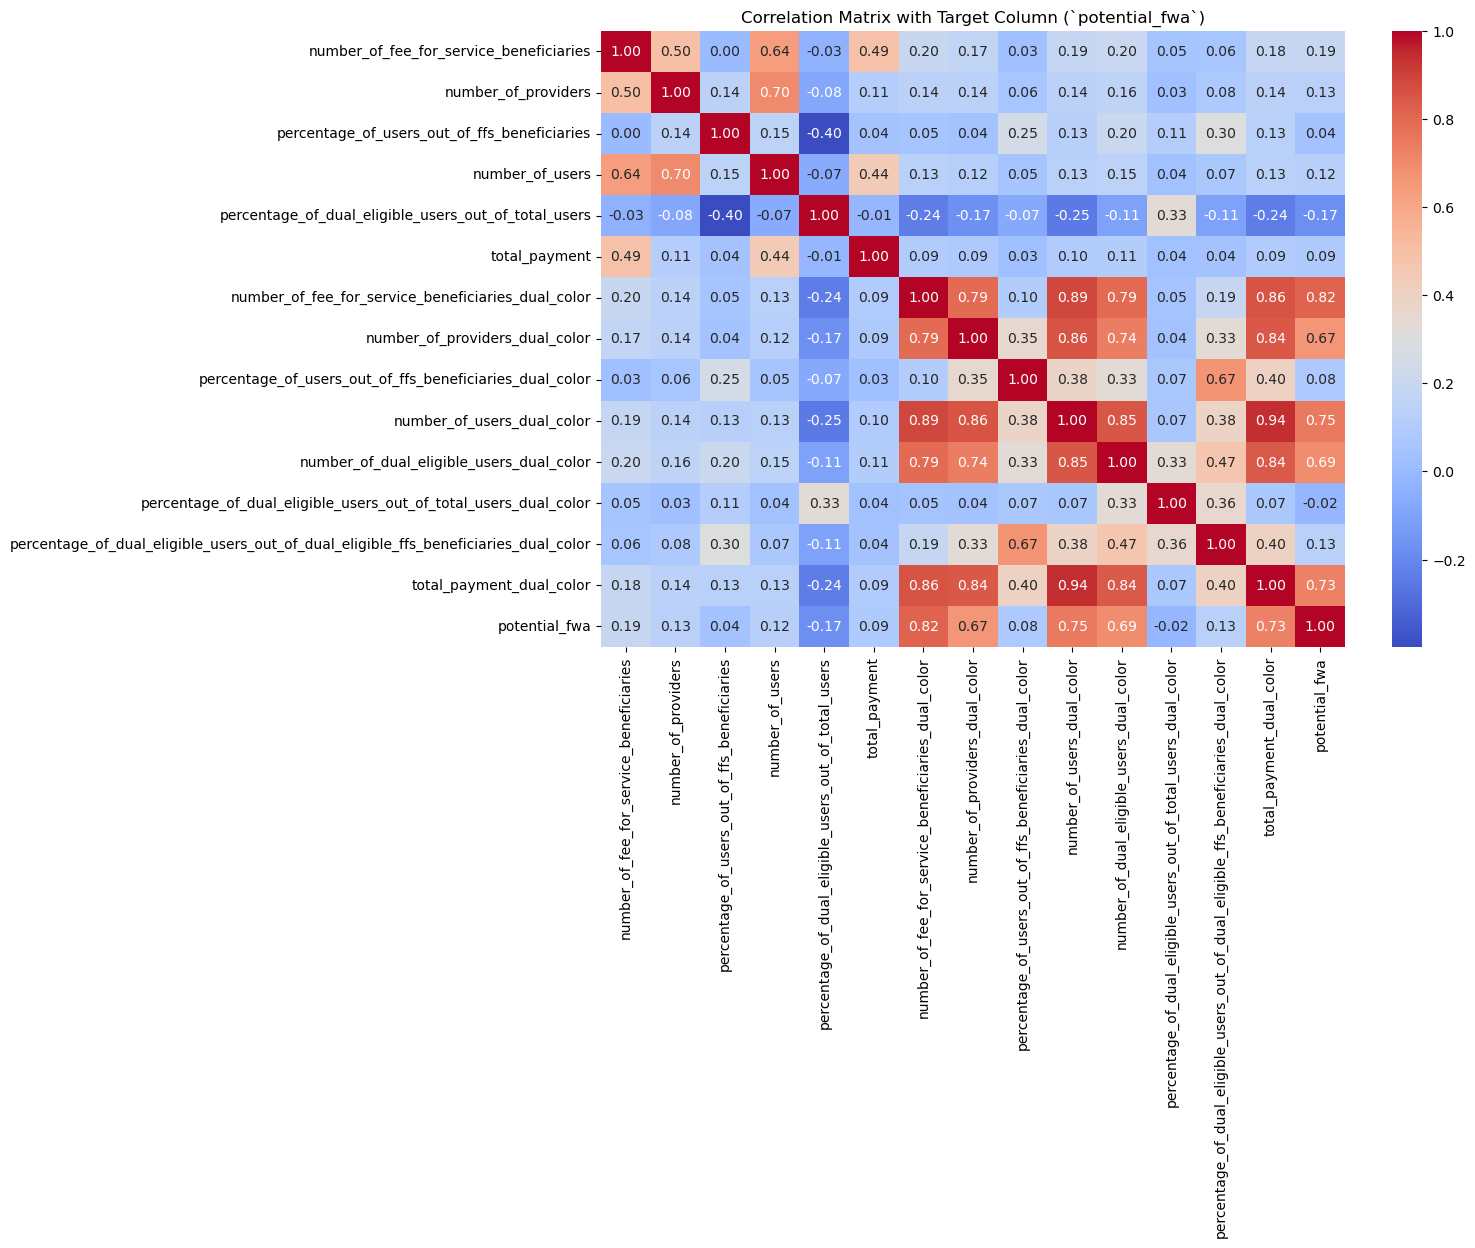

In [68]:
# visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Target Column (`potential_fwa`)')
plt.show()

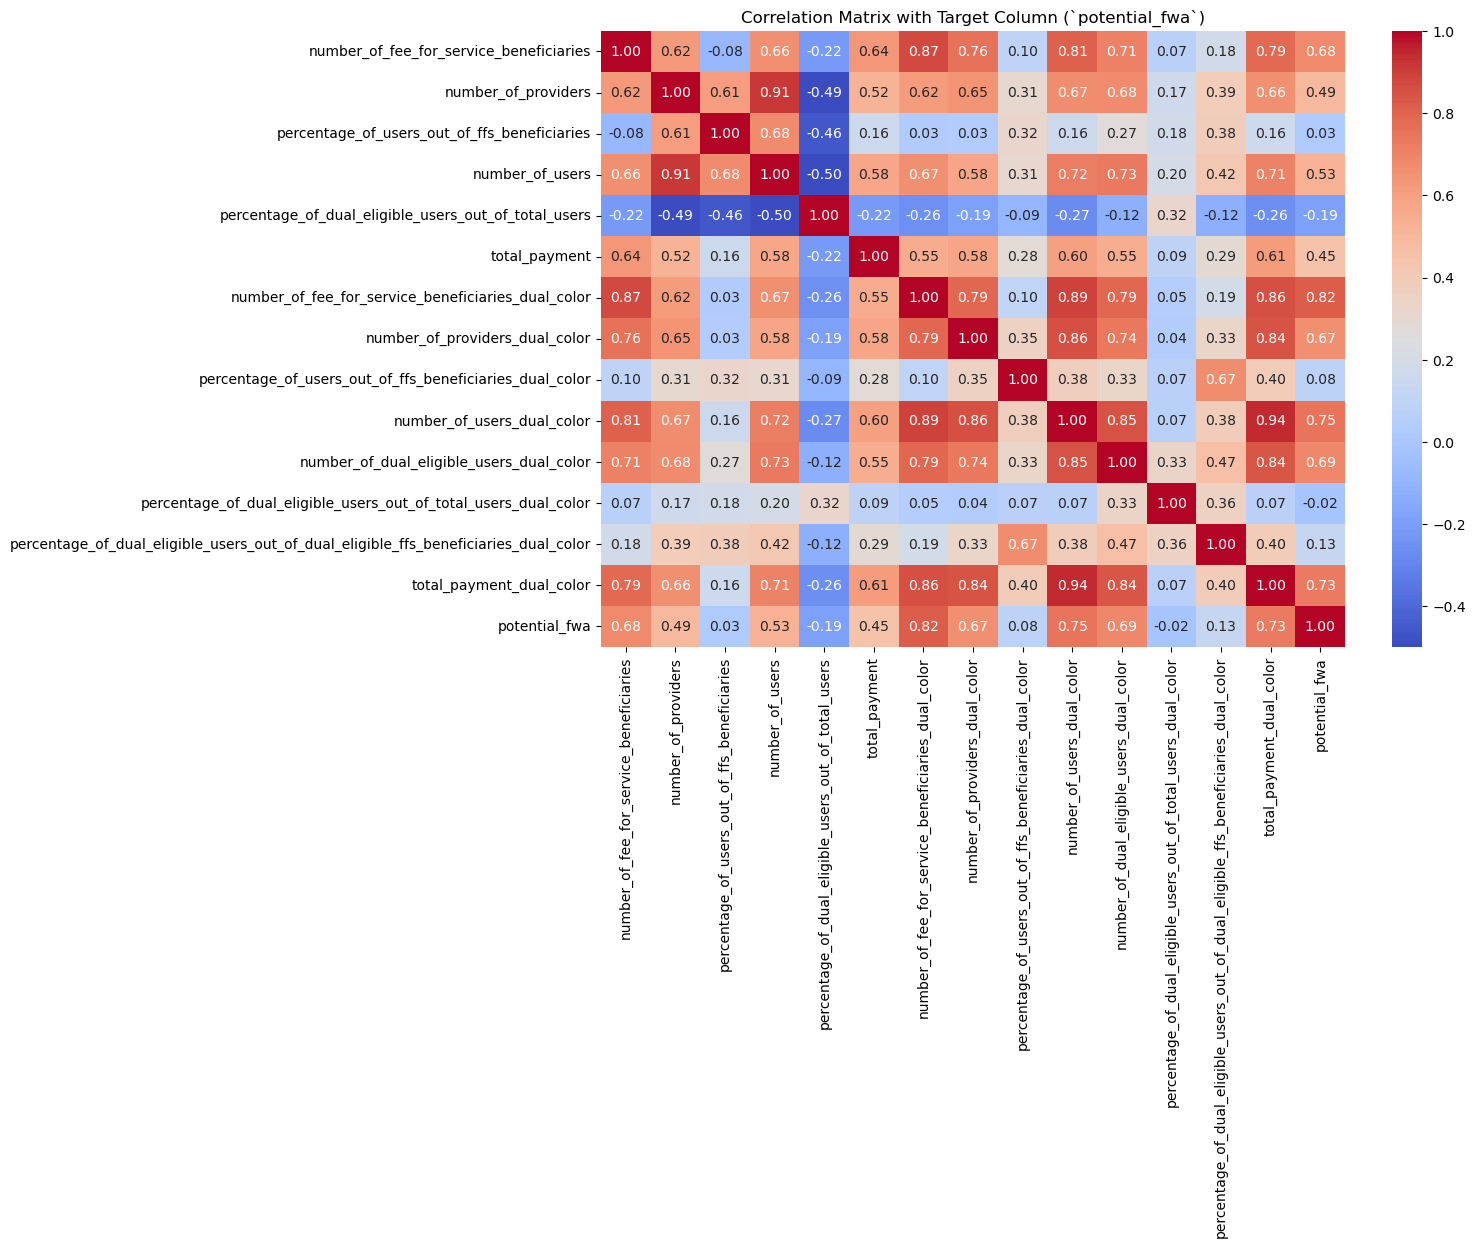

In [70]:
# visualize correlation heatmap with the transformed data
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_transformed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Target Column (`potential_fwa`)')
plt.show()

We will remove the following columns due to their high p-values, multicollinearity, and minimal correlation with the target variable:

- `moratorium`
- `reference_period`

Additionally, the columns `number_of_fee_for_service_beneficiaries_dual_color` and `total_payment_dual_color` will be dropped as they derived the `potential_fwa` variable.

In [71]:
# list of columns to drop
columns_to_drop = [
    'moratorium',
    'number_of_fee_for_service_beneficiaries_dual_color',
    'reference_period',
    'total_payment_dual_color'
]

# drop the specified columns from df
df = df.drop(columns=columns_to_drop)
df.sample(5)

# drop the specified columns from df
data_transformed = data_transformed.drop(columns=columns_to_drop)
data_transformed.sample(5)

,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,percentage_of_dual_eligible_users_out_of_total_users,total_payment,number_of_providers_dual_color,percentage_of_users_out_of_ffs_beneficiaries_dual_color,number_of_users_dual_color,number_of_dual_eligible_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,potential_fwa
654096,Ophthalmology,NM,QUAY,35,037,-0.621113,0.615821,0.927000,0.259242,-1.366773,0.234727,2,1,1,1,2,1,0
661868,Preventive Health Services,AR,LAWRENCE,05,075,-0.371972,1.309390,1.724675,0.857124,0.754255,-0.360423,3,3,2,1,1,1,0
349625,Physical & Occupational Therapy,OK,MURRAY,40,099,-0.356985,-0.057543,-0.193951,-0.349369,-0.756751,-0.210799,3,3,2,2,3,3,0
580100,Home Health,VA,BRUNSWICK,51,025,-0.363213,-0.057543,0.171503,-0.076459,0.170360,0.770309,3,4,2,2,4,4,0
63628,Ambulance (Emergency & Non-Emergency),RI,BRISTOL,44,001,0.172023,0.615821,0.530376,0.535625,-1.074781,0.364554,4,4,3,2,1,3,0


#### Feature Engineering 

In [ ]:
# One hot Encode

# Get list of columns to encode
columns_to_encode = cat_data.iloc[:,7:].columns
columns_to_encode = columns_to_encode.to_list()

# Perform one-hot encoding on all columns
df_encoded = pd.get_dummies(cat_data, columns=columns_to_encode, prefix='Encoded')

In [ ]:
df_encoded.sample(20)

In [ ]:
df_encoded.info()